# Figures

In [146]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [147]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [148]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [149]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [150]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [151]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span = df_span[['_200_' in f for f in df_span['file']]]
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [152]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


file modification   cell  \
298  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1  Huvec   
61   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me3     H1   
56   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K27me3  HepG2   
313  /home/jetbrains/data/2023_GSE26320/span/GSM646...     H3K27me3  HepG2   
169  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me3   K562   

    replicate  peaks         tool dataset  
298      rep1  72976         SPAN  ENCODE  
61       rep1  34064        MACS2  ENCODE  
56       rep1   4259        MACS2  ENCODE  
313      rep2  24590         SPAN  ENCODE  
169      rep1  25323  MACS2 broad  ENCODE

In [153]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/50 [00:00<?, ?it/s]

SPAN 46


file modification  cell  \
103  /home/jetbrains/data/2023_Immune/sicer/PBMC_H3...     H3K36me3  PBMC   
155  /home/jetbrains/data/2023_Immune/span/CD4_H3K2...     H3K27me3   CD4   
51   /home/jetbrains/data/2023_Immune/macs2/CD34_H3...      H3K4me1  CD34   
104  /home/jetbrains/data/2023_Immune/sicer/CD4_H3K...      H3K4me3   CD4   
24   /home/jetbrains/data/2023_Immune/macs2/CD4_H3K...      H3K27ac   CD4   

    replicate   peaks         tool  dataset  
103             28026        SICER  Roadmap  
155             40966         SPAN  Roadmap  
51       rep2  136538  MACS2 broad  Roadmap  
104             20030        SICER  Roadmap  
24              61162        MACS2  Roadmap

In [154]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

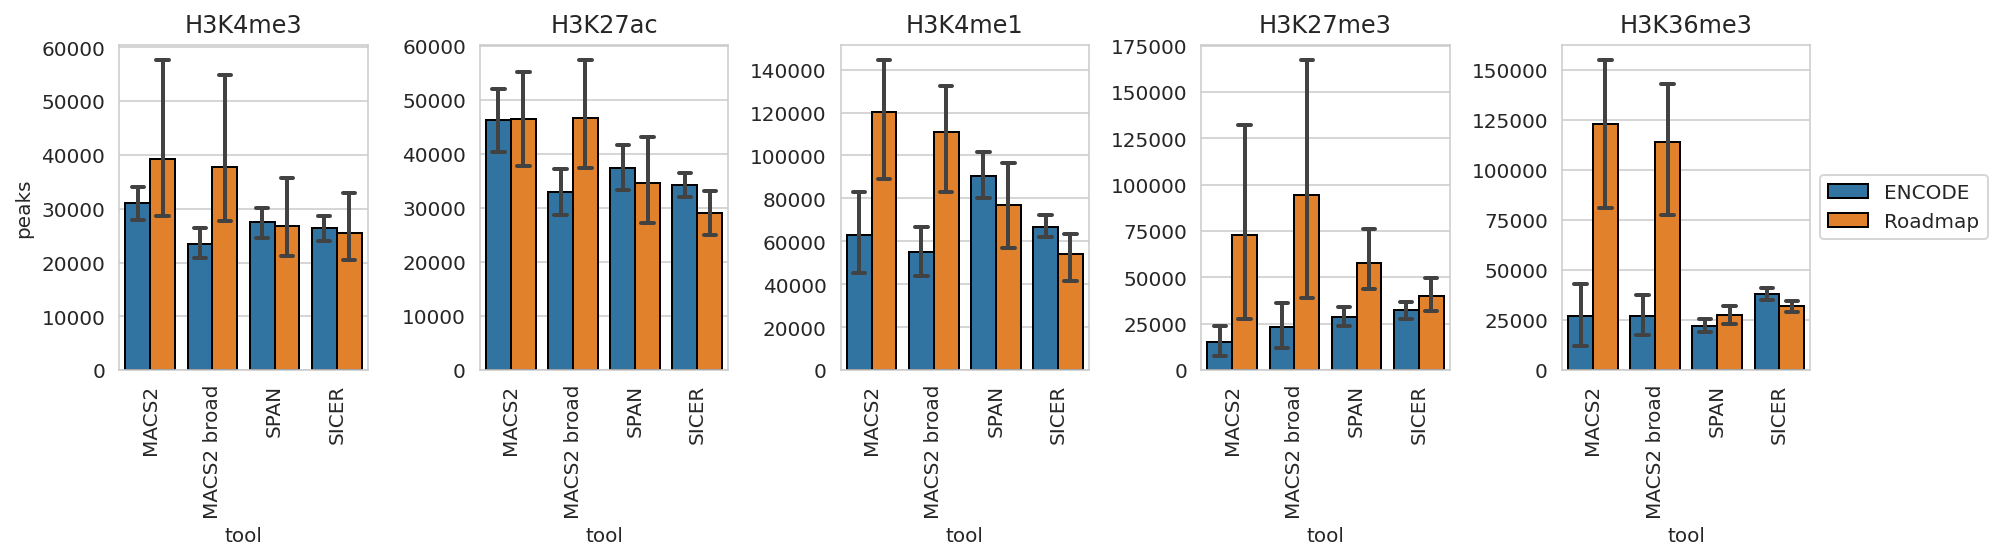

In [155]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

H3K4me3 ENCODE


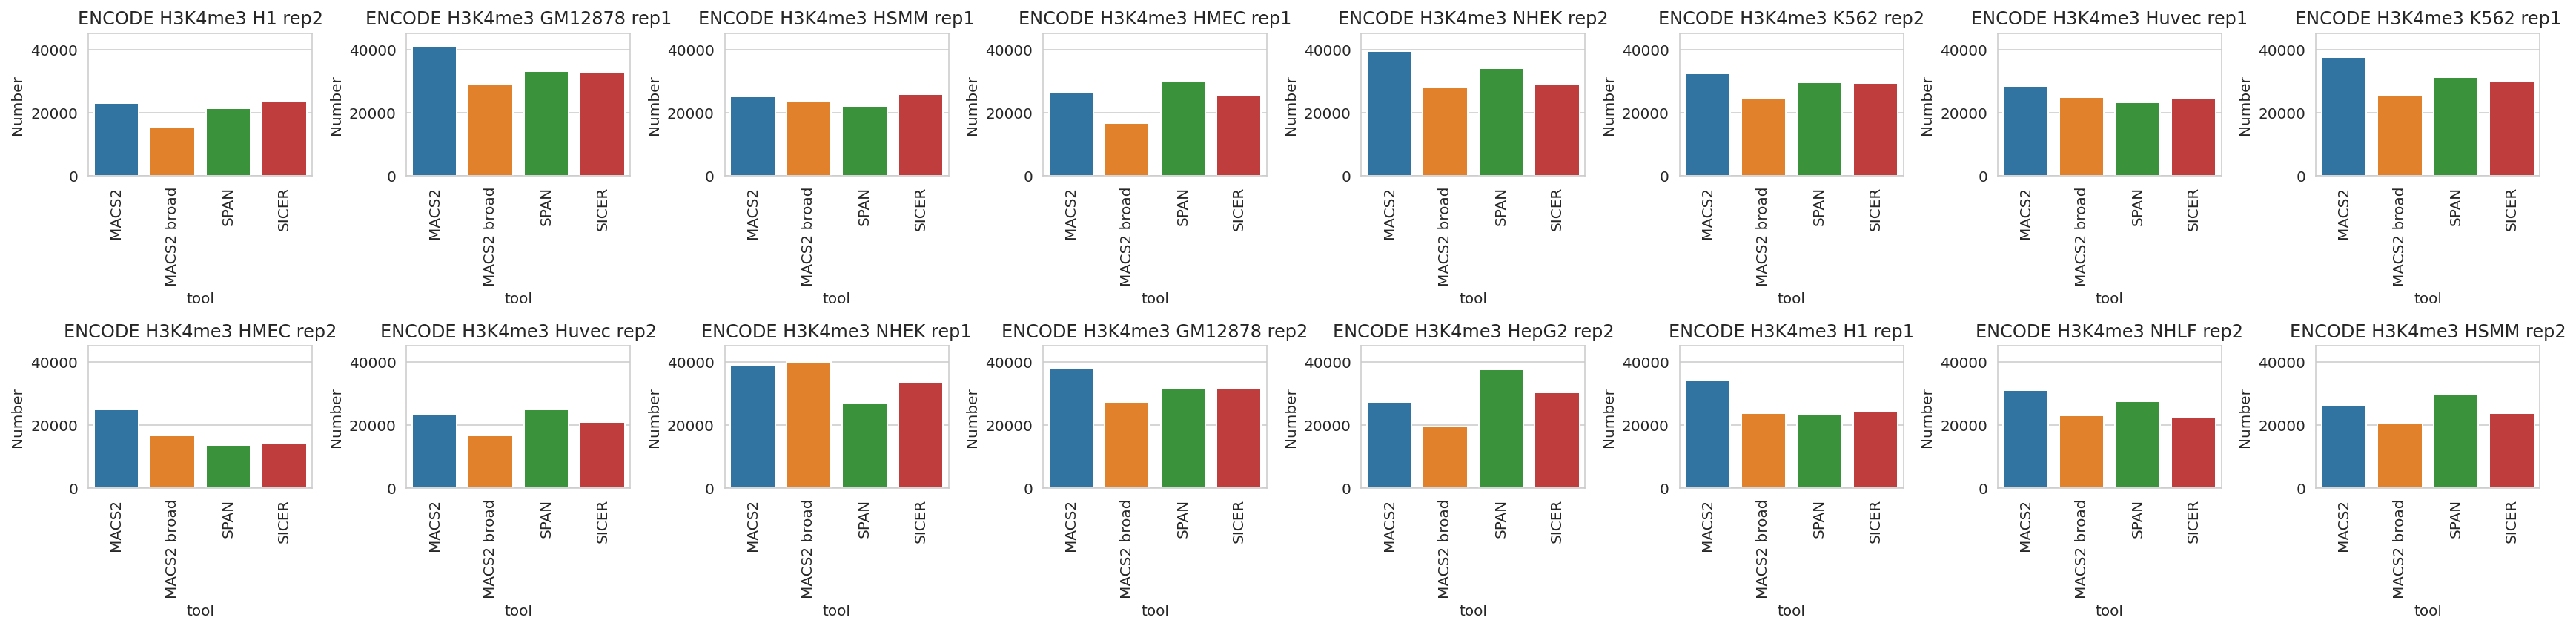

H3K4me3 Roadmap


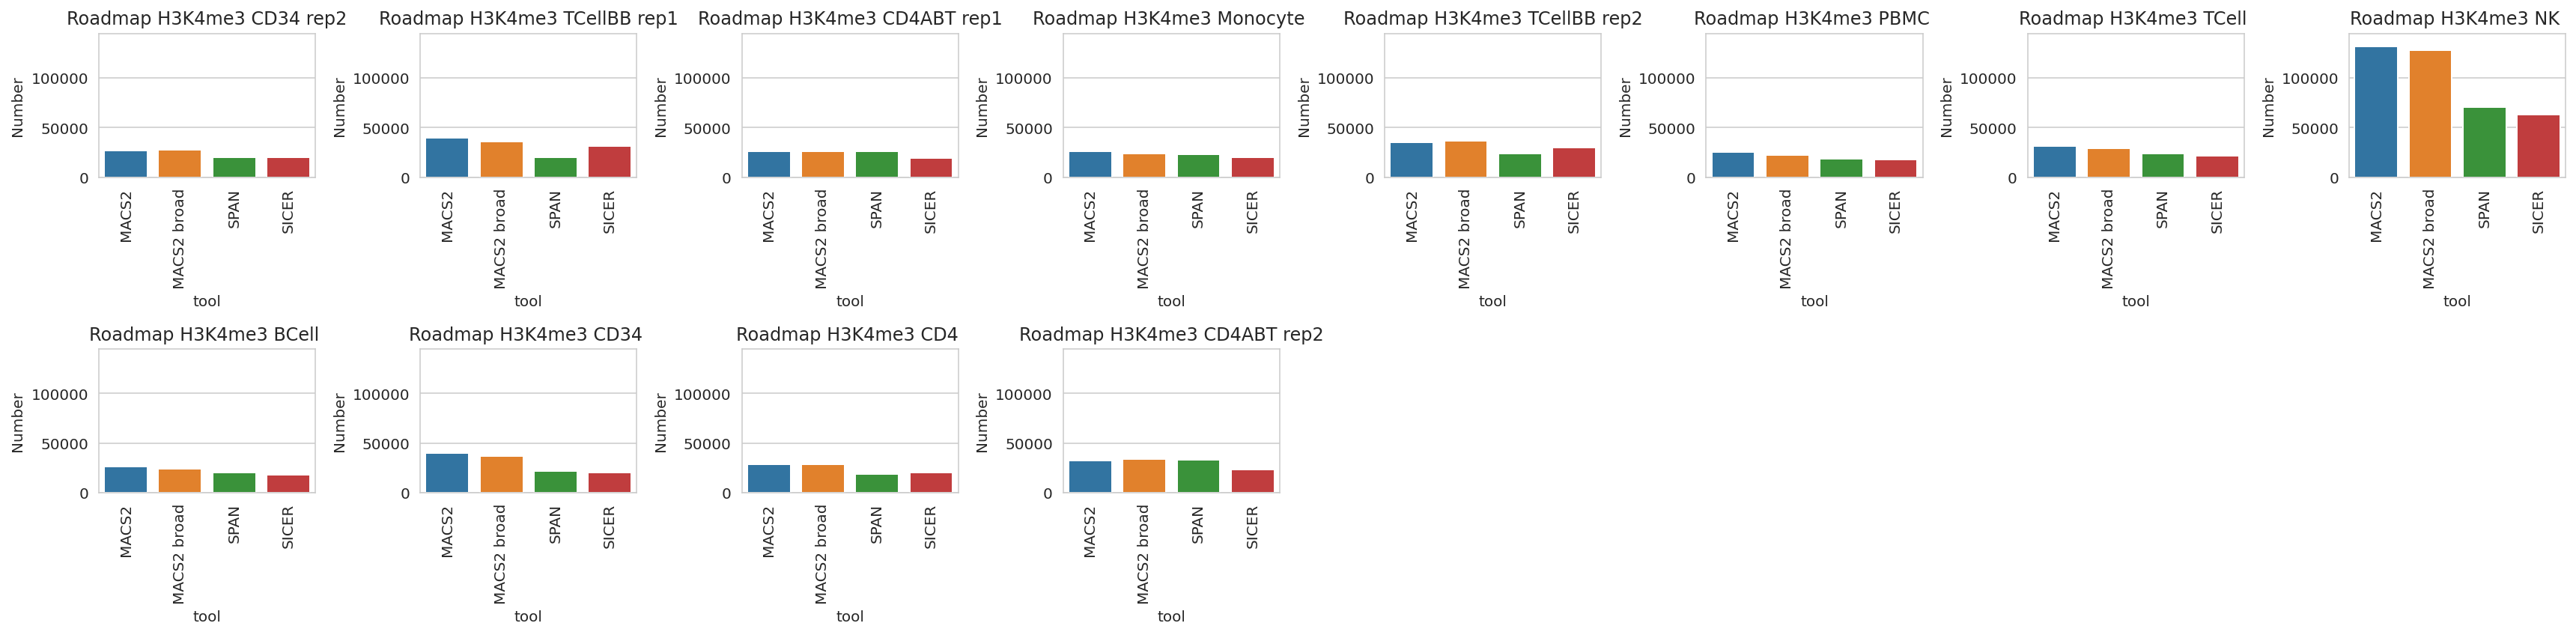

H3K27ac ENCODE


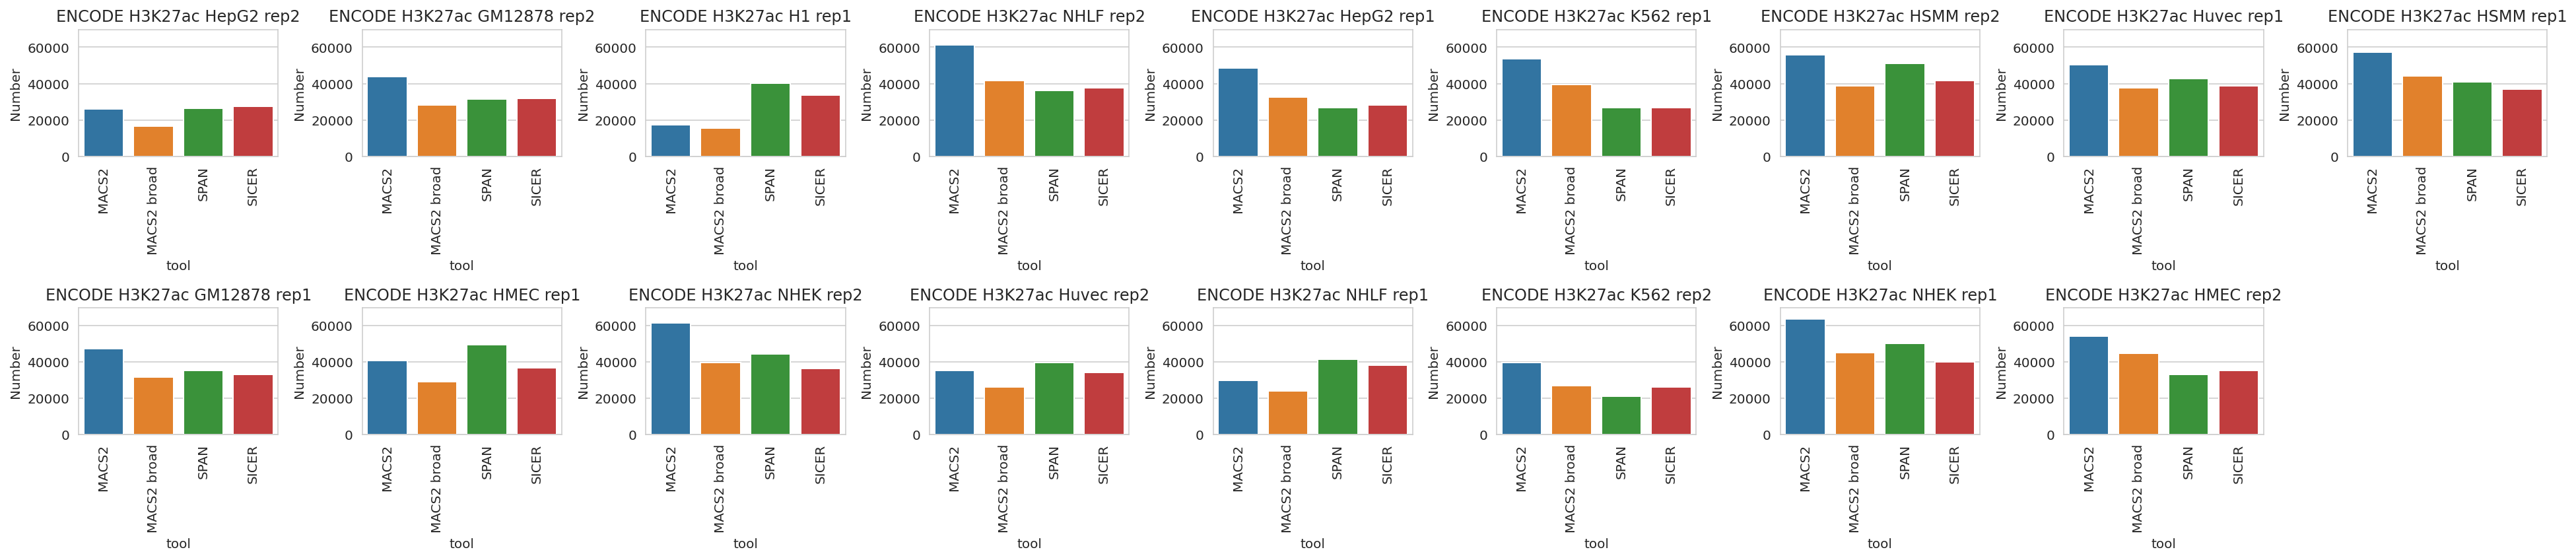

H3K27ac Roadmap


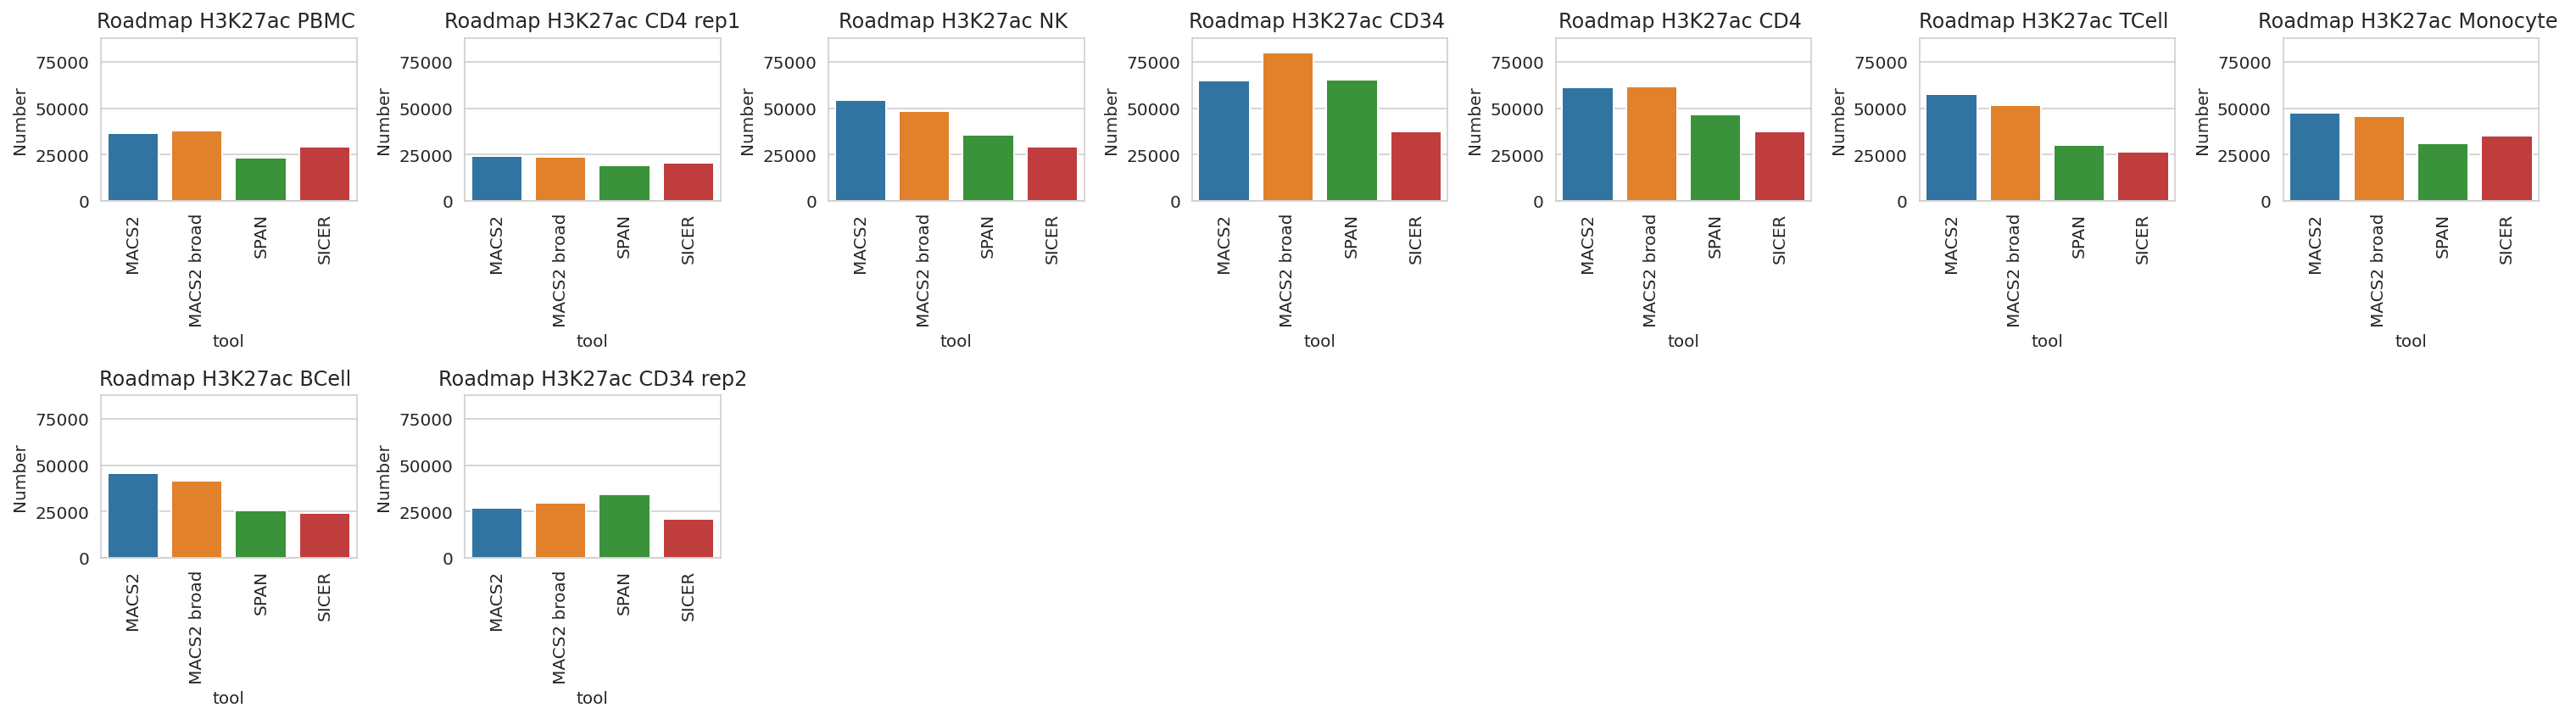

H3K4me1 ENCODE


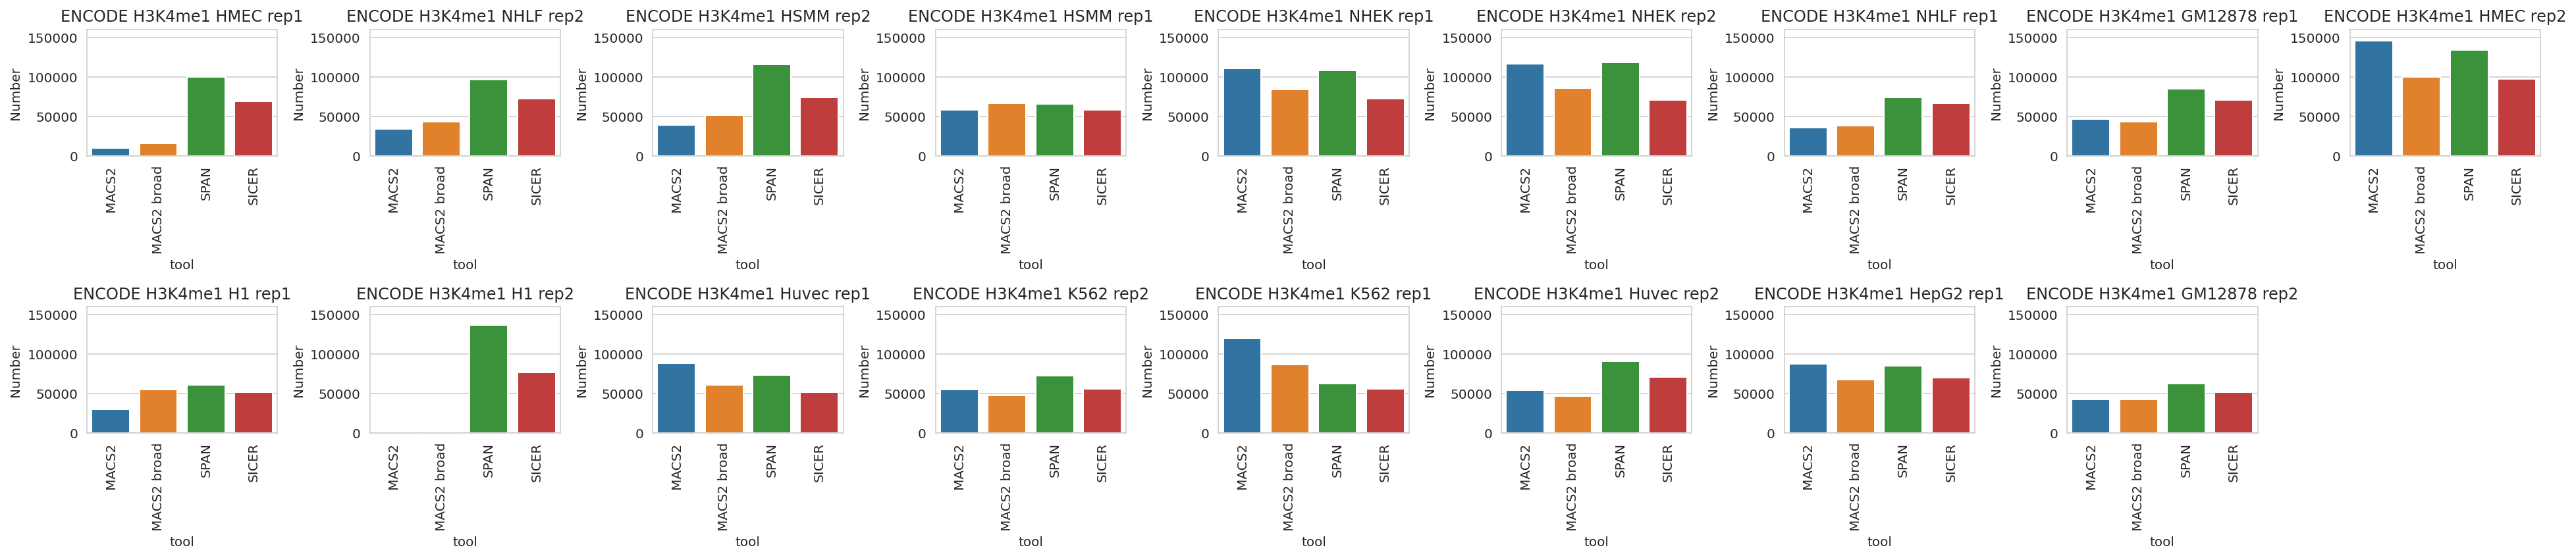

H3K4me1 Roadmap


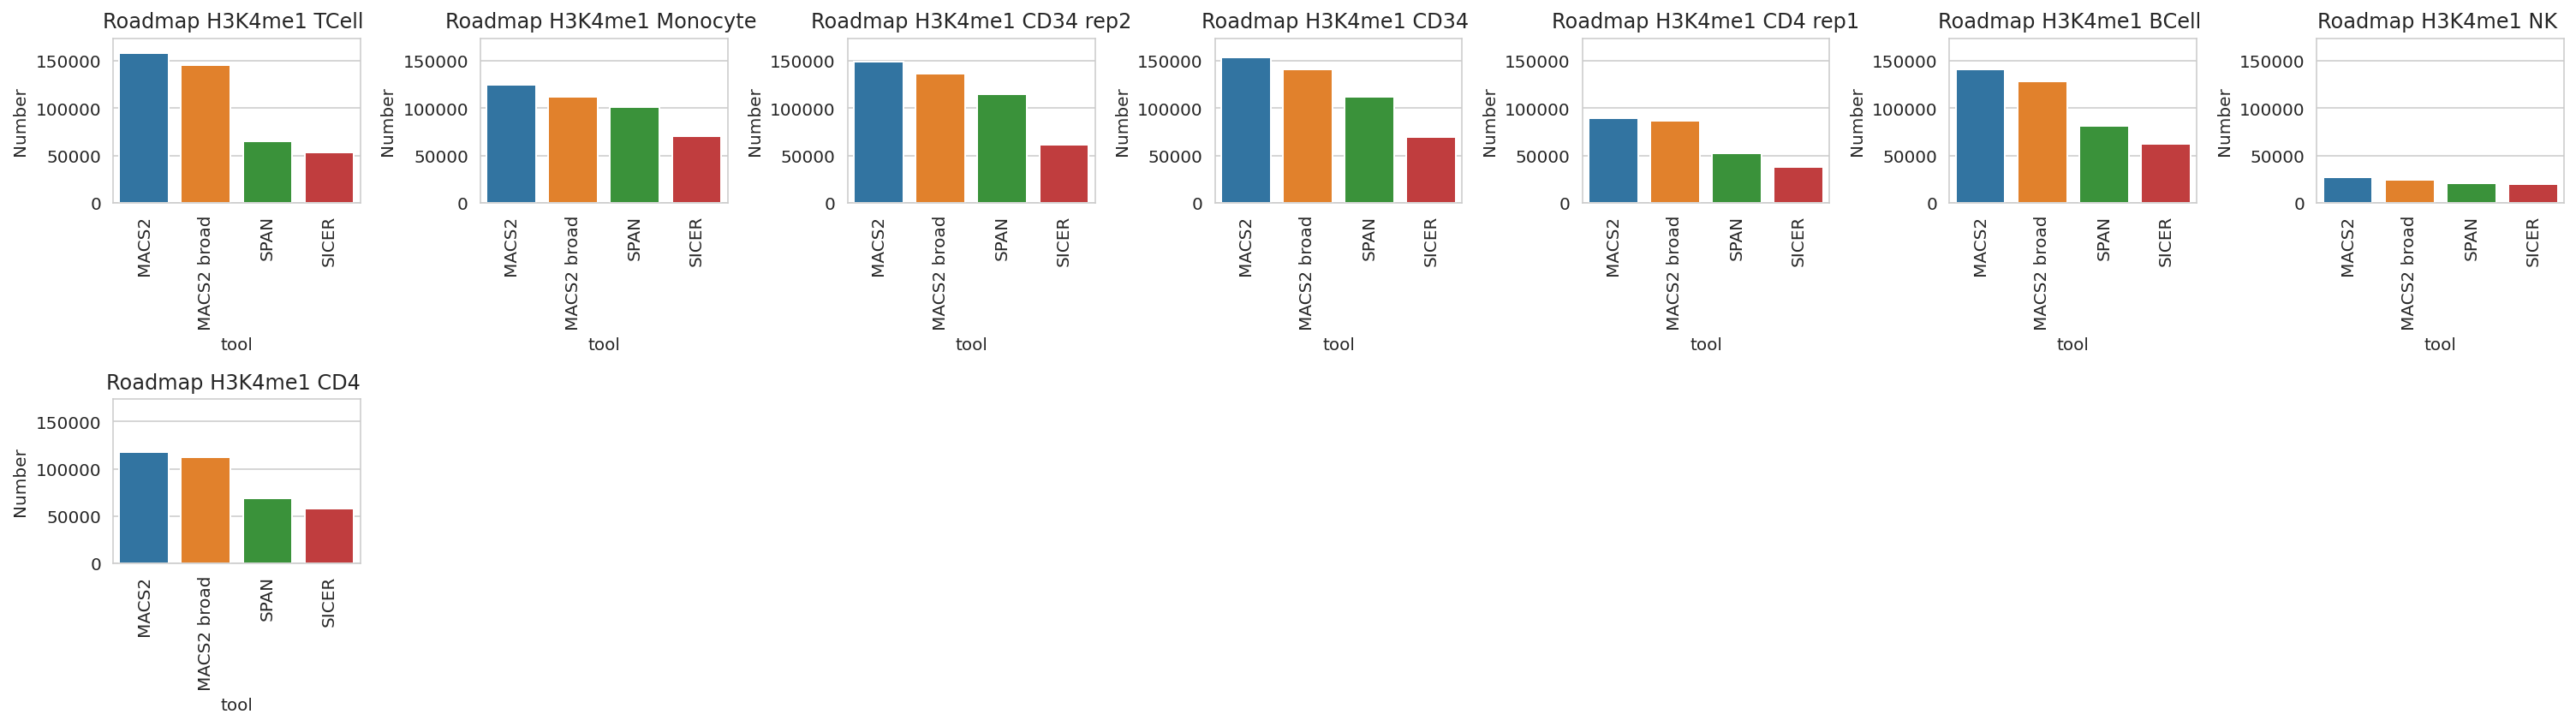

H3K27me3 ENCODE


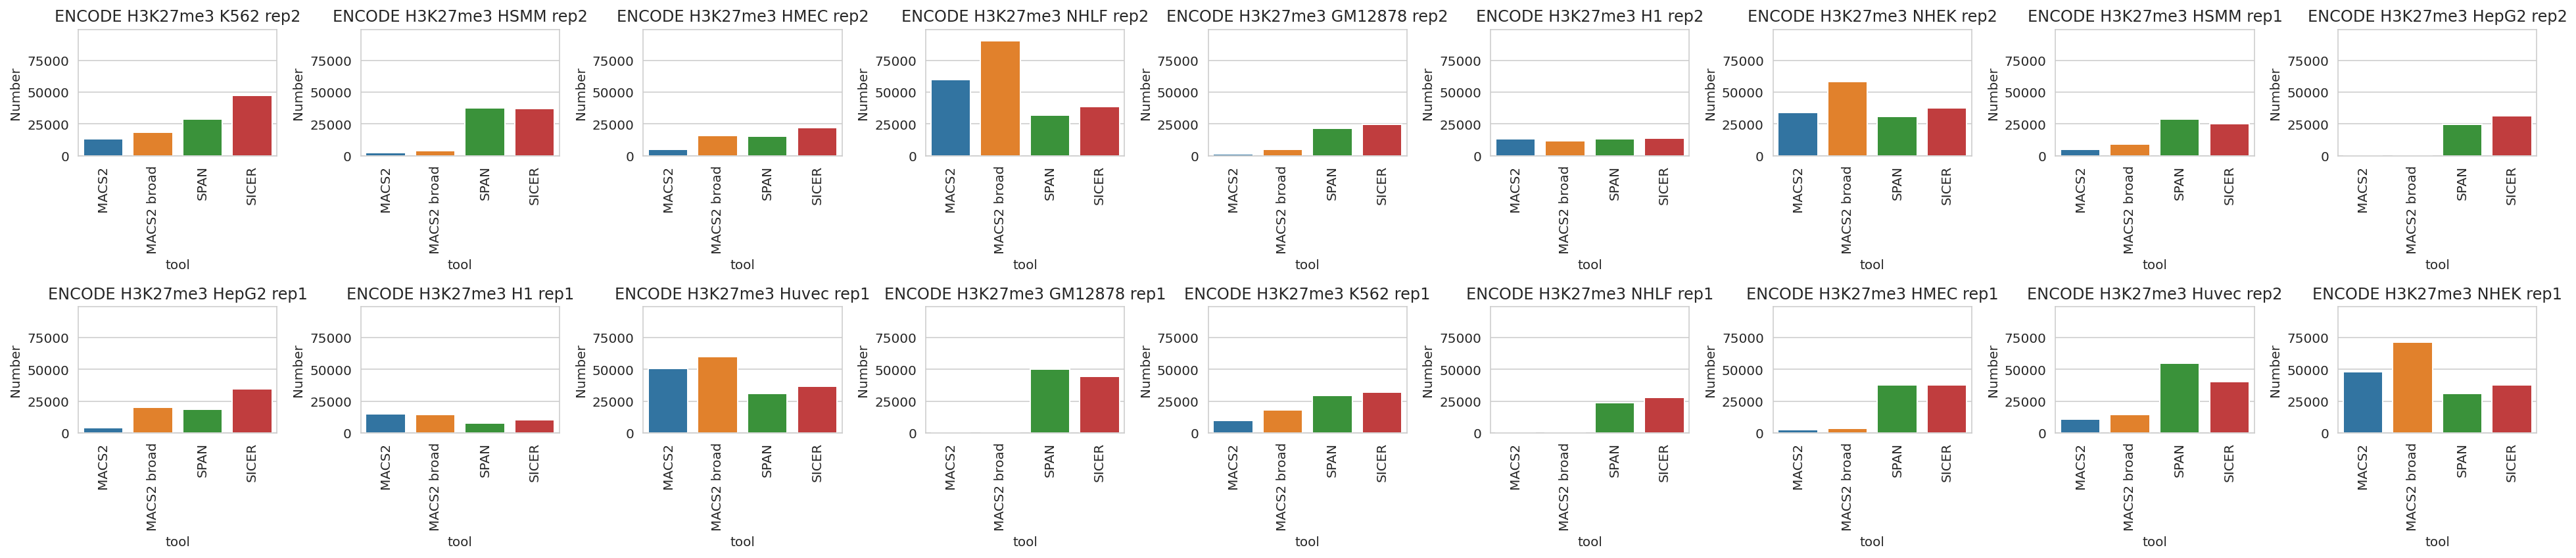

H3K27me3 Roadmap


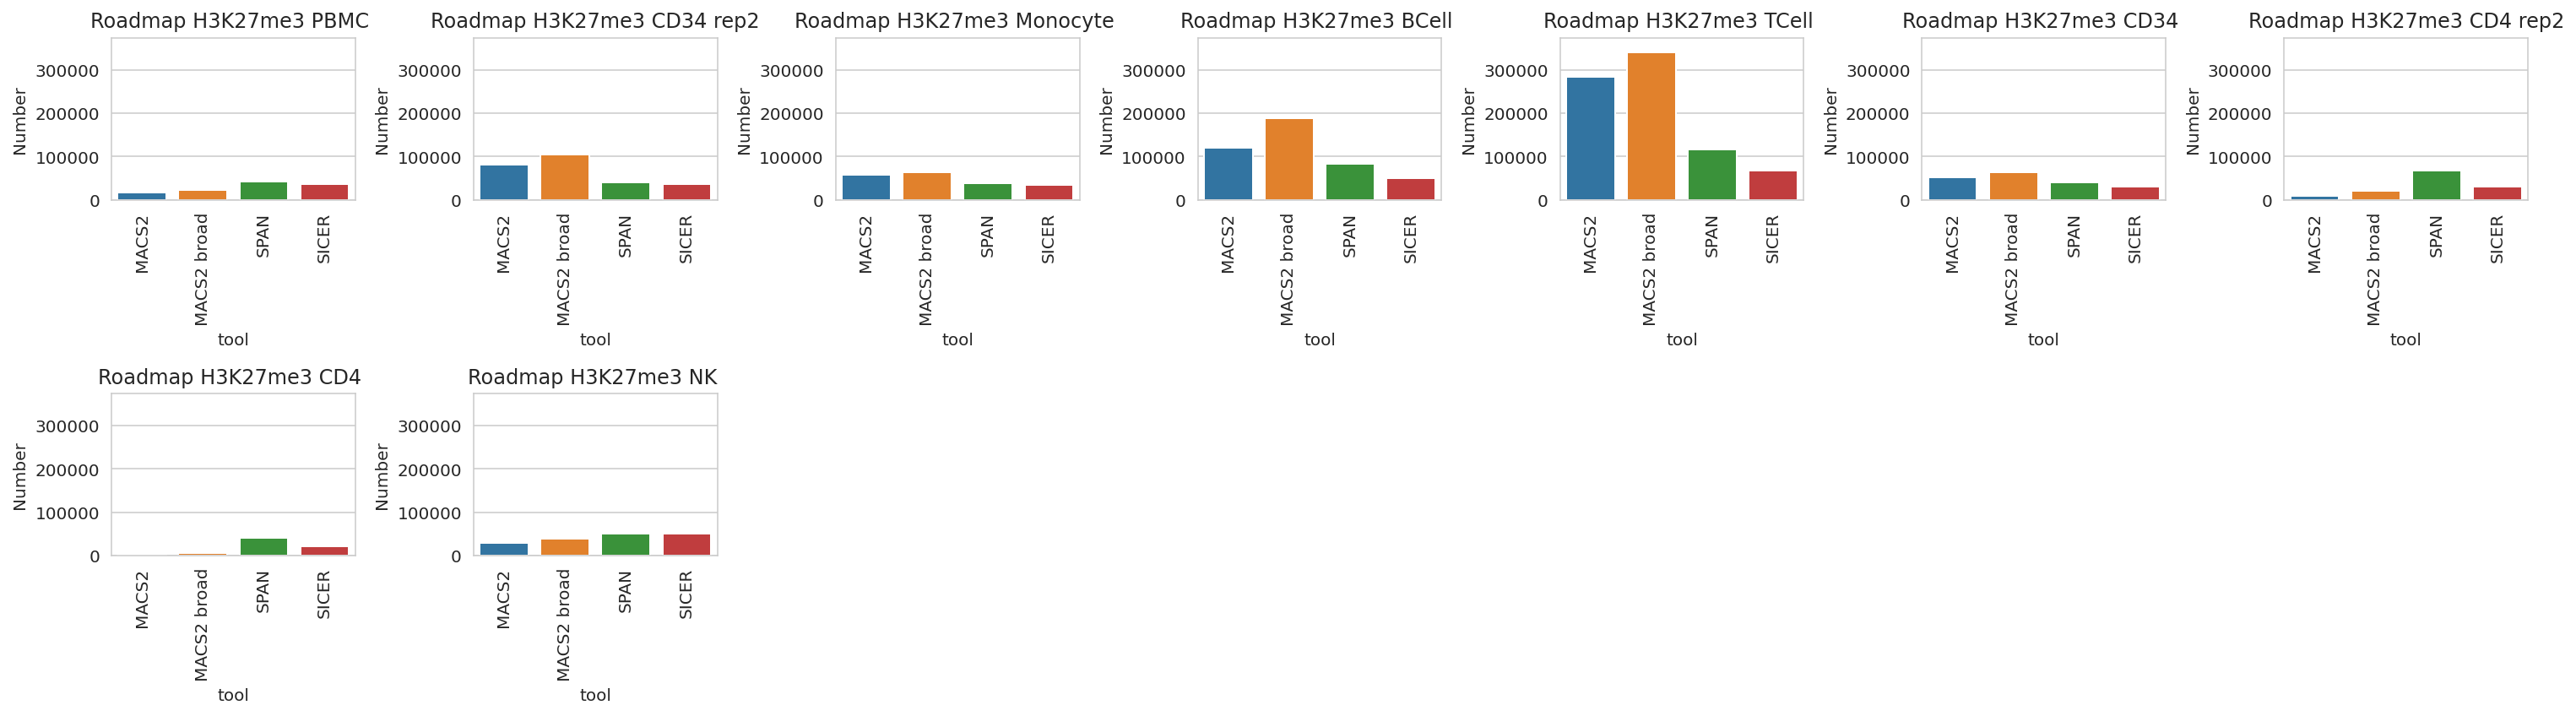

H3K36me3 ENCODE


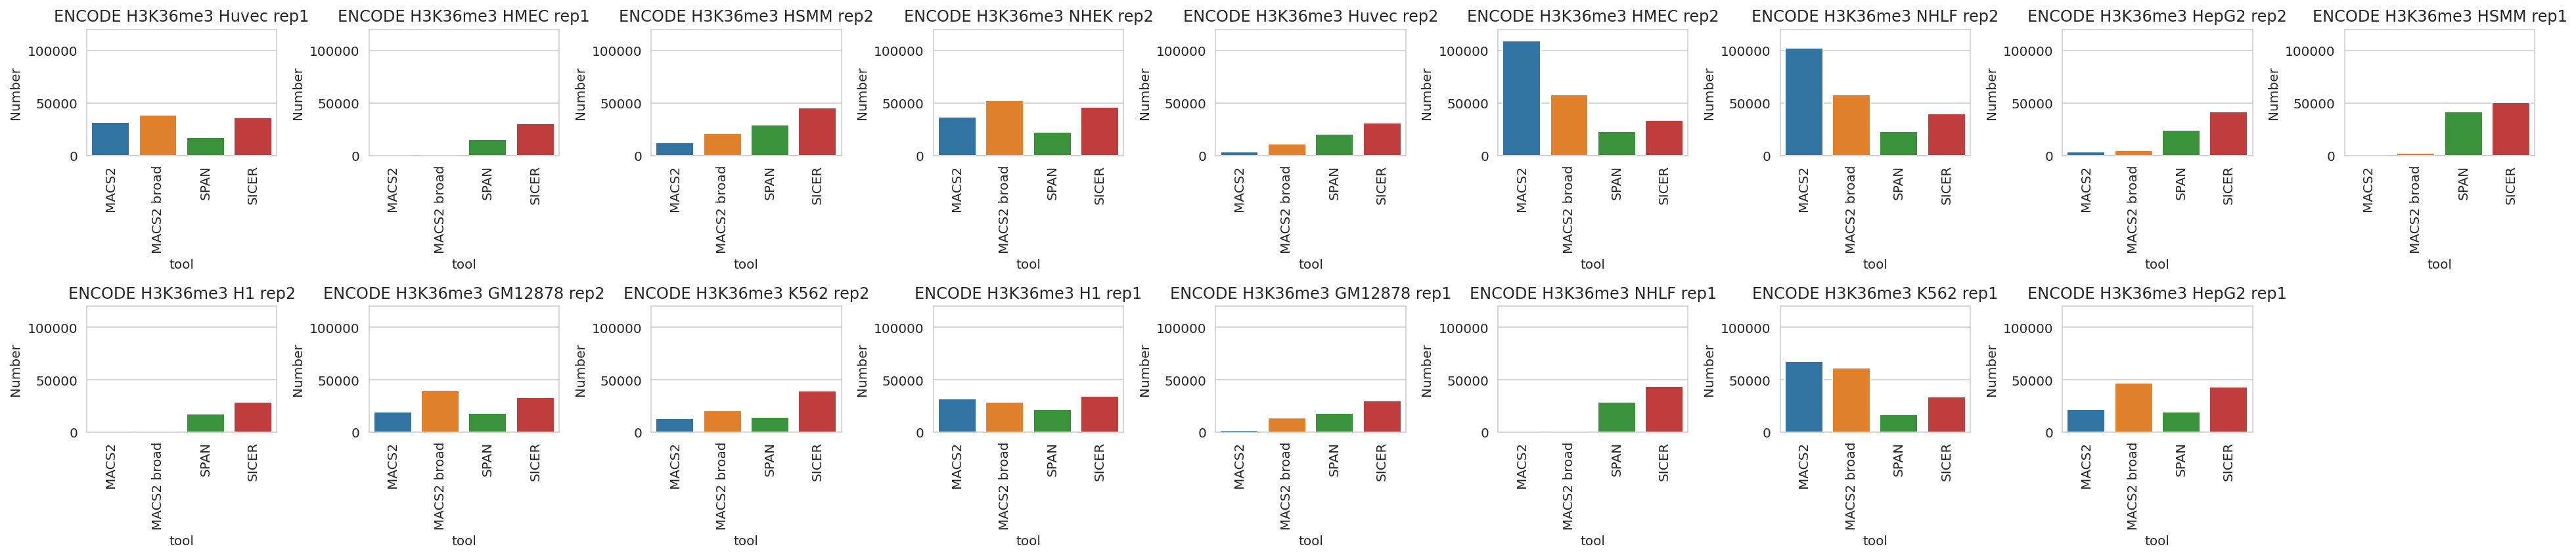

H3K36me3 Roadmap


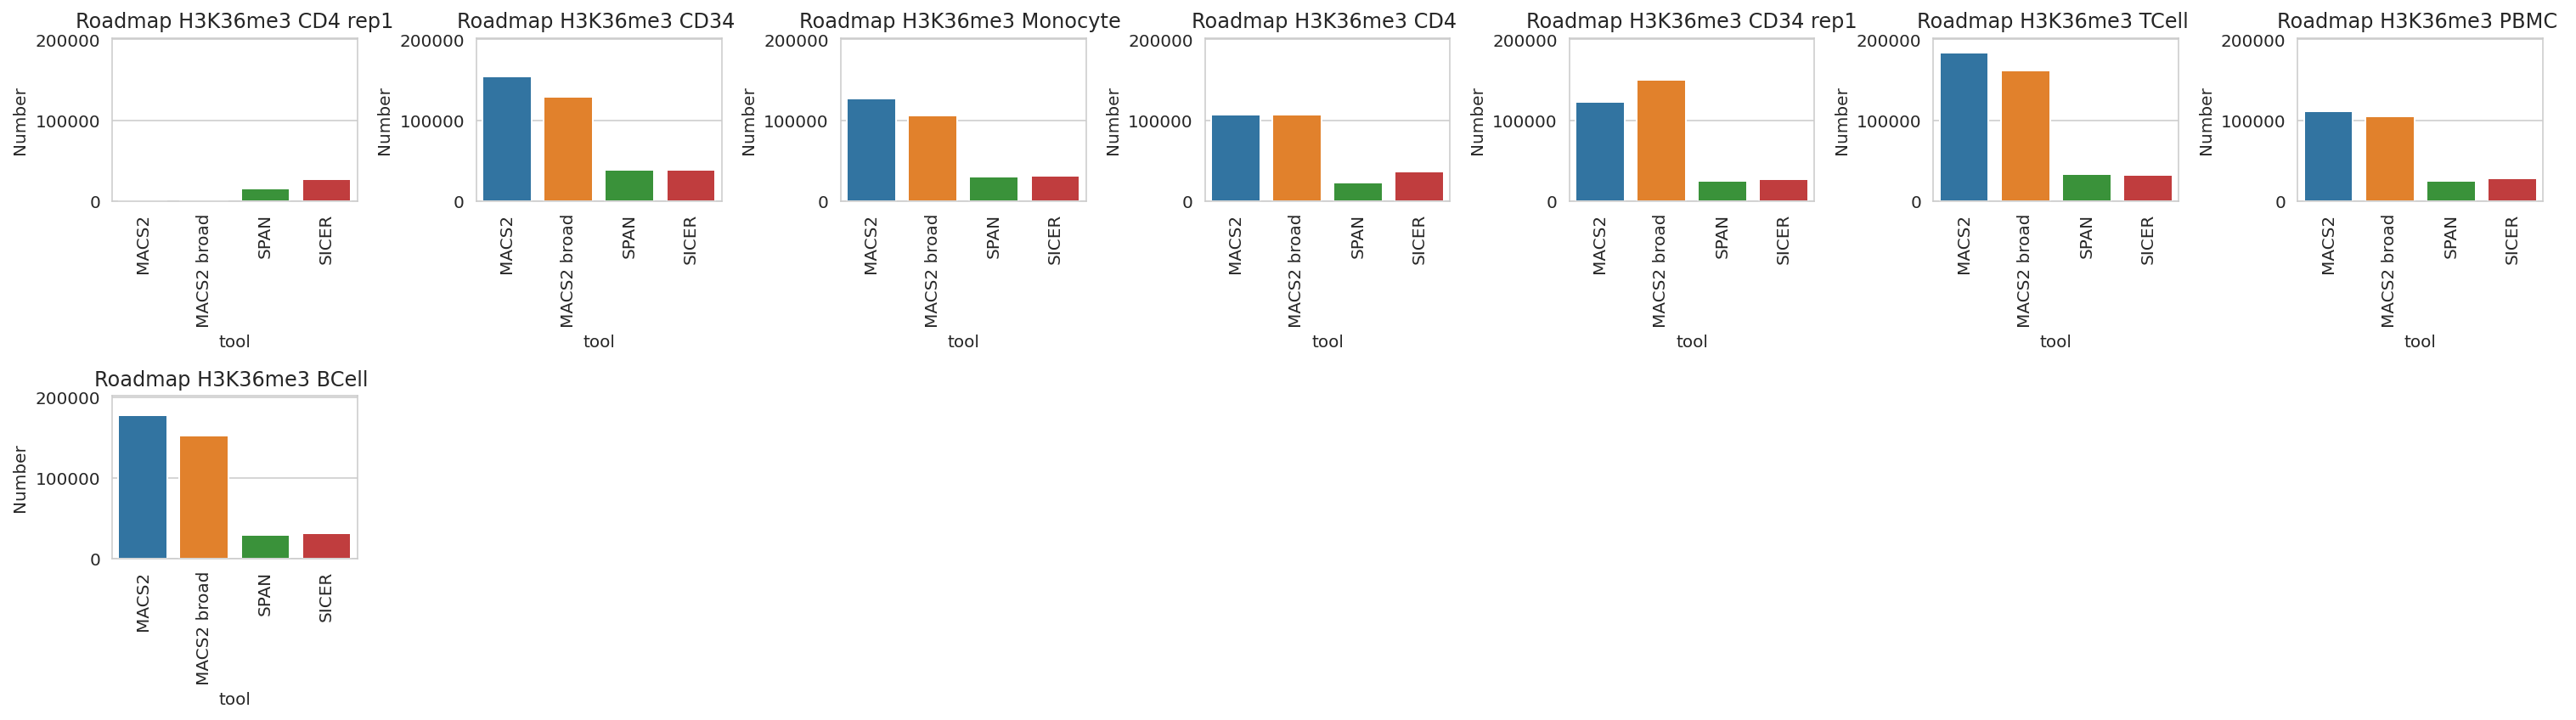

In [156]:
import math
for m, ds in product(MODIFICATIONS, ['ENCODE', 'Roadmap']):
    print(m, ds)
    t = df_peaks[(df_peaks['dataset'] == ds) & (df_peaks['modification'] == m)]
    experiments = [(c, r) for _, (c, r) in t[['cell', 'replicate']].drop_duplicates().iterrows()]
    ncols = int(math.ceil(math.sqrt(len(experiments)) + 4))
    nrows = int(math.ceil(len(experiments) / ncols))
    plt.figure(figsize=(3 * ncols, 3 * nrows))
    axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
    for i, (c, r) in enumerate(experiments):
        ax = axs[i]
        ax.title.set_text(f'{ds} {m} {c} {r}')
        g_results = sns.barplot(data=t[(t['cell'] == c) & (t['replicate']==r)],
                            x='tool', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                            )
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_ylabel('Number')
        ax.set_ylim(0, t['peaks'].max() * 1.1)
    plt.tight_layout()
    plt.show()

In [157]:
# Remove outliers
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', ''),
            ('H3K27me3', 'H1', 'rep1'),
            ('H3K27me3', 'HMEC', 'rep2'),
            ('H3K27me3', 'NHLF', 'rep2'),
            ('H3K27me3', 'HepG2', 'rep1'),
            ('H3K27me3', 'GM12878', 'rep1')]
df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]]

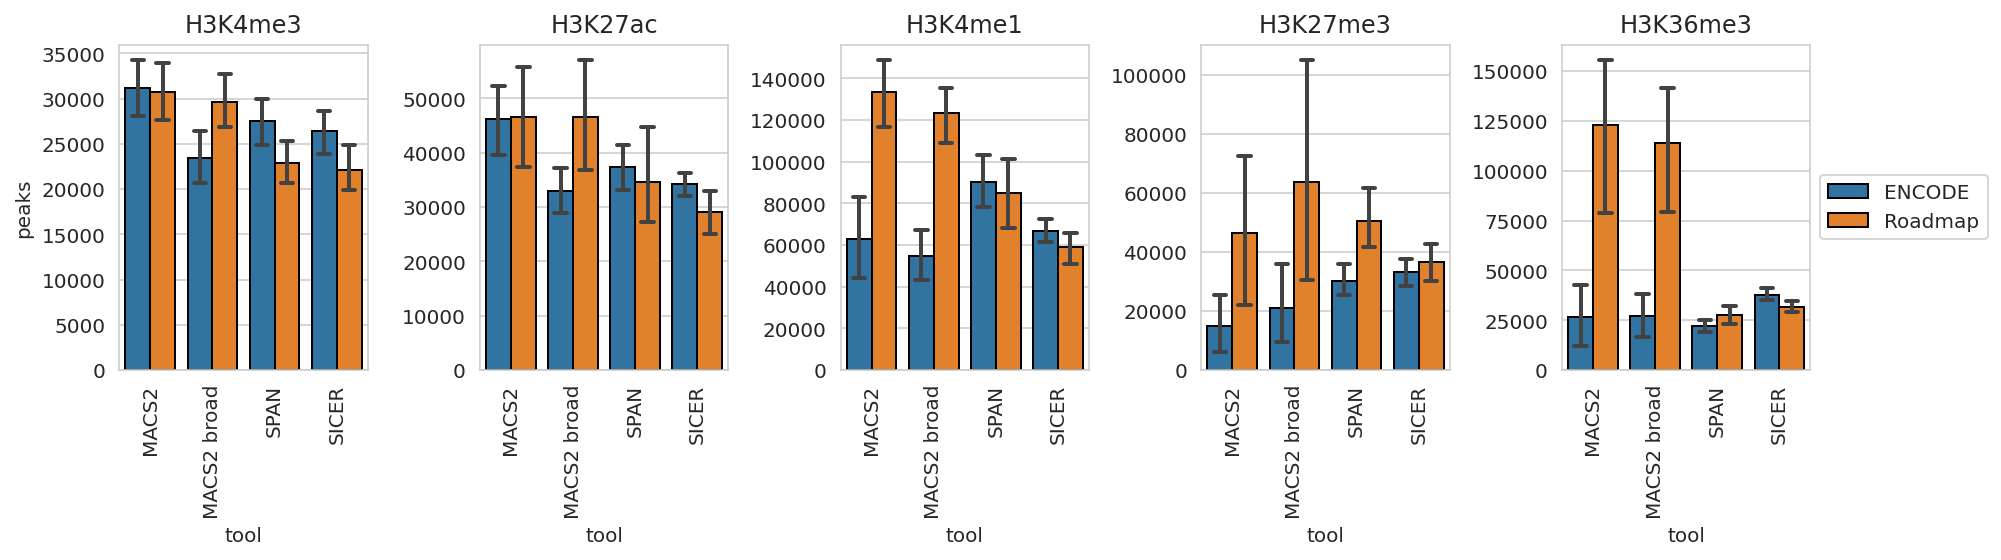

In [158]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

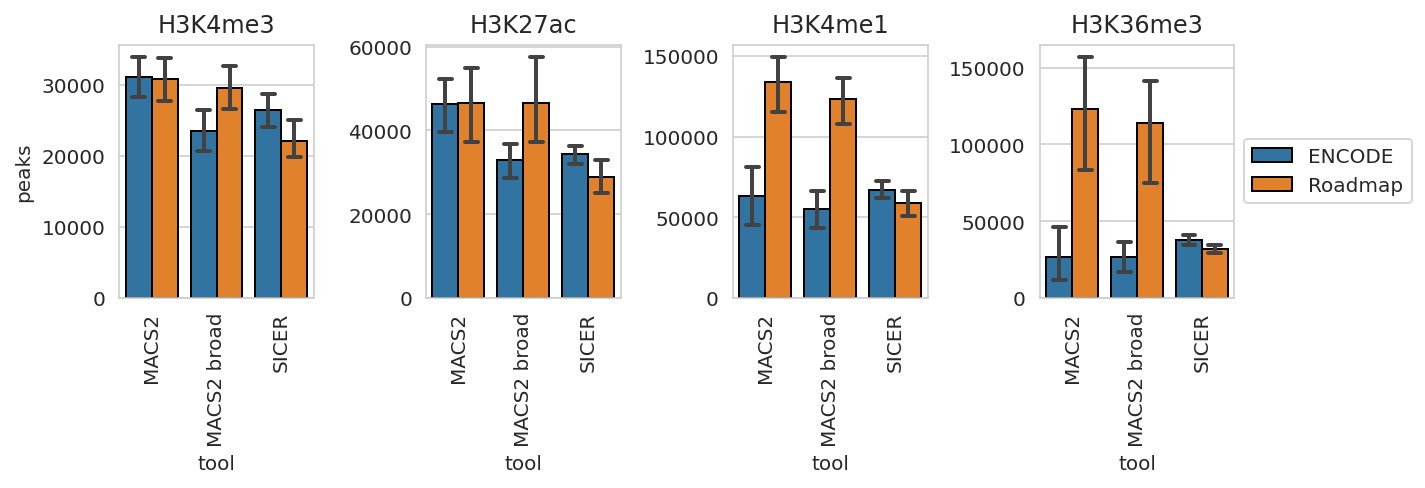

In [159]:
plt.figure(figsize=(10, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SICER']
                            )
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Lengths

In [160]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length  dataset modification     cell replicate         tool
901367    1192.0   ENCODE      H3K4me1     K562      rep1  MACS2 broad
718571    4268.0   ENCODE      H3K27ac     HSMM      rep1  MACS2 broad
2165332  12399.0   ENCODE     H3K36me3  GM12878      rep1        SICER
203737     358.0   ENCODE     H3K36me3     HSMM      rep2        MACS2
2693646   1899.0   ENCODE      H3K27ac     HMEC      rep1         SPAN
2705418  35066.0   ENCODE     H3K36me3     K562      rep2         SPAN
3866538   1999.0  Roadmap      H3K27ac      CD4      rep1        SICER
230077     338.0   ENCODE     H3K36me3     NHEK      rep2        MACS2
3518629    278.0  Roadmap      H3K4me3     CD34            MACS2 broad
1693699    999.0   ENCODE      H3K4me1    Huvec      rep2        SICER

ENCODE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


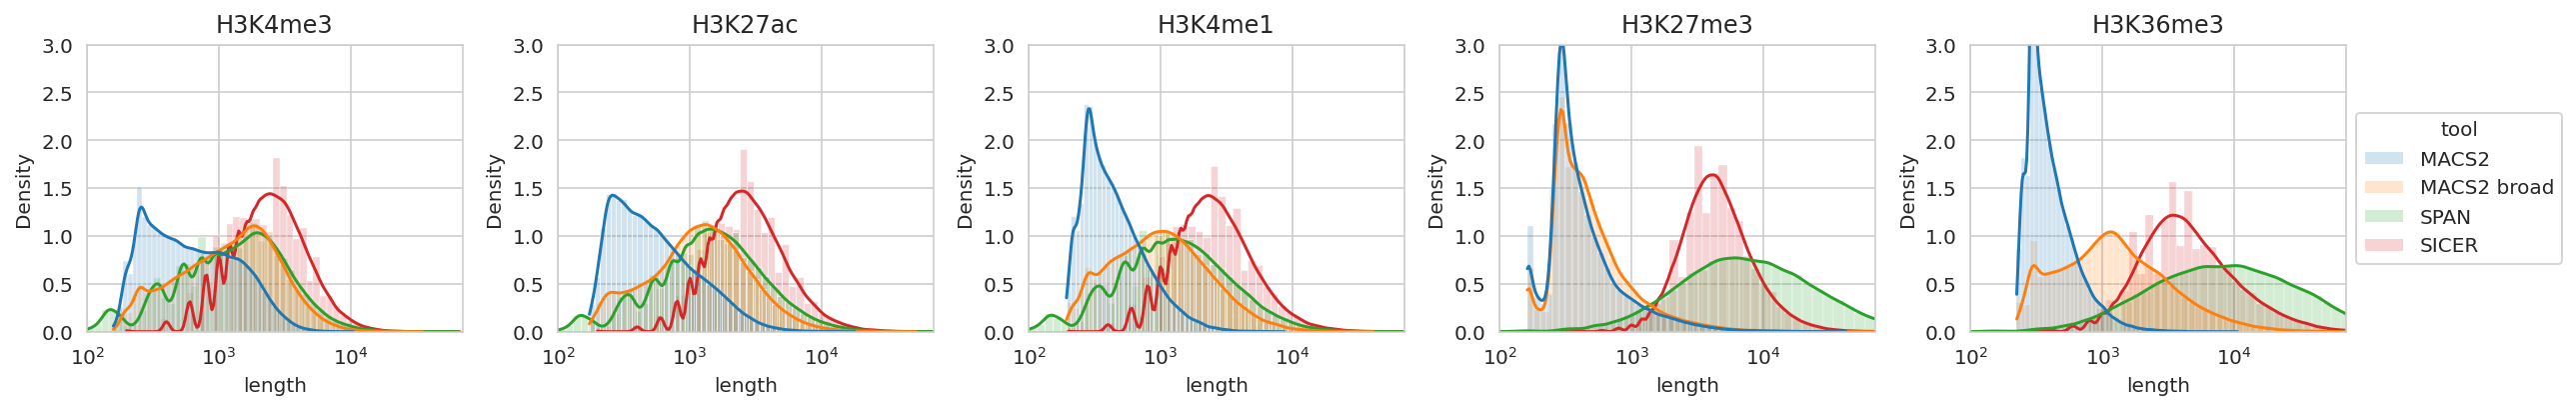

Roadmap


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


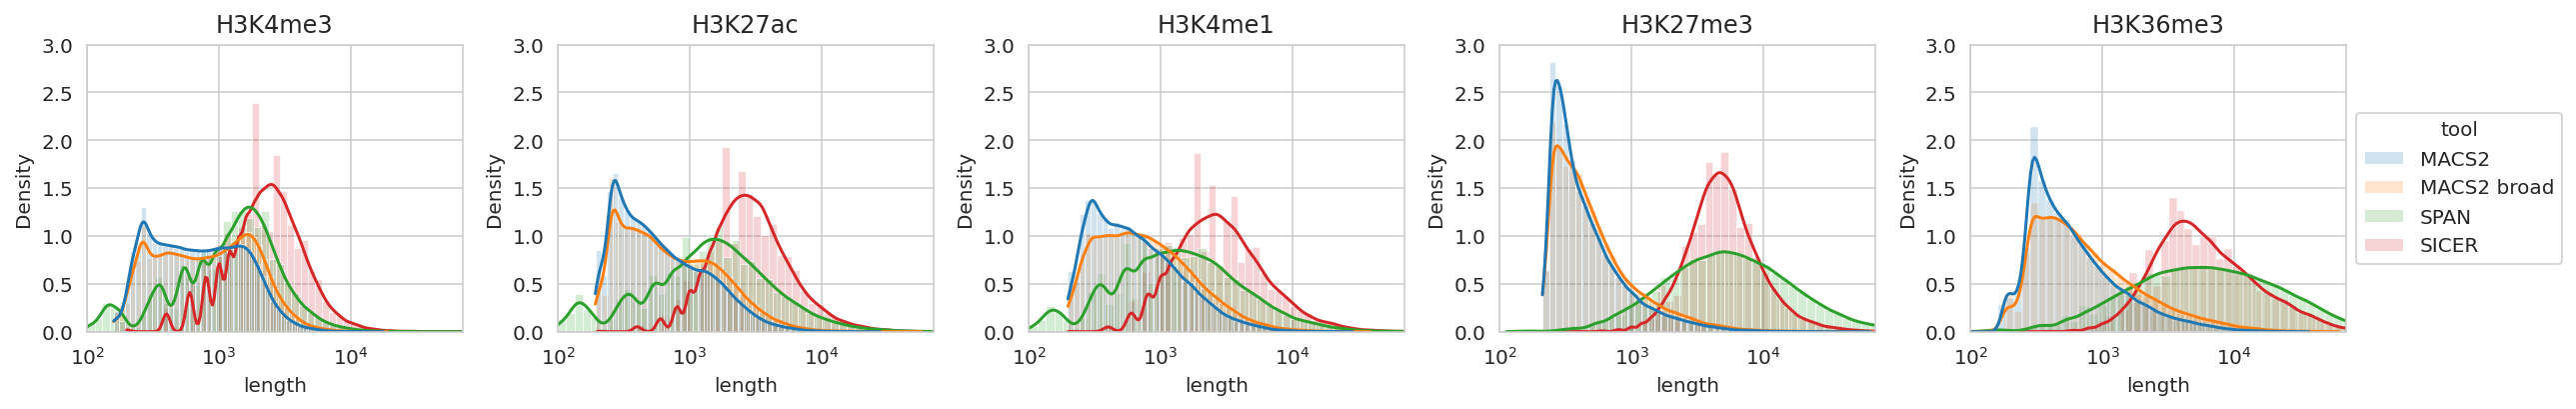

In [161]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(18, 3))    
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['dataset'] == ds) & (t['modification'] == m)], 
                                 x='length', hue='tool', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=50, kde=True, log_scale=True, alpha=0.2,
                                 palette=TOOLS_PALETTE,
                                 hue_order=TOOLS)
        g_results.set(xscale='log')
        g_results.set_ylim(0, 3)
        g_results.set_xlim(1e2, 7e4)
        ax.title.set_text(m)
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()    
    

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


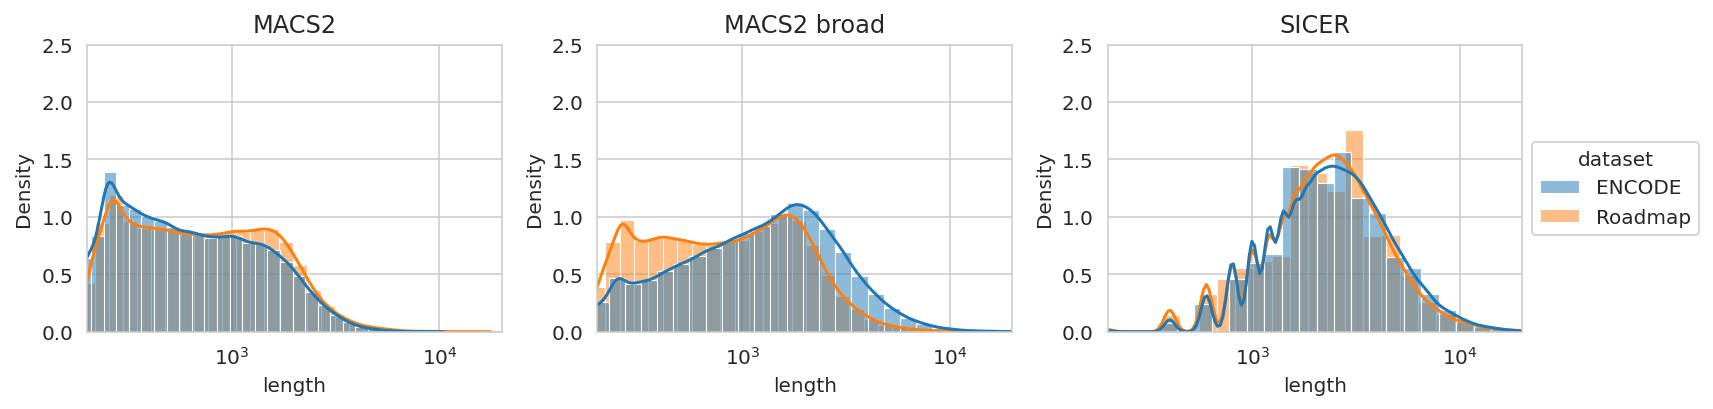

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


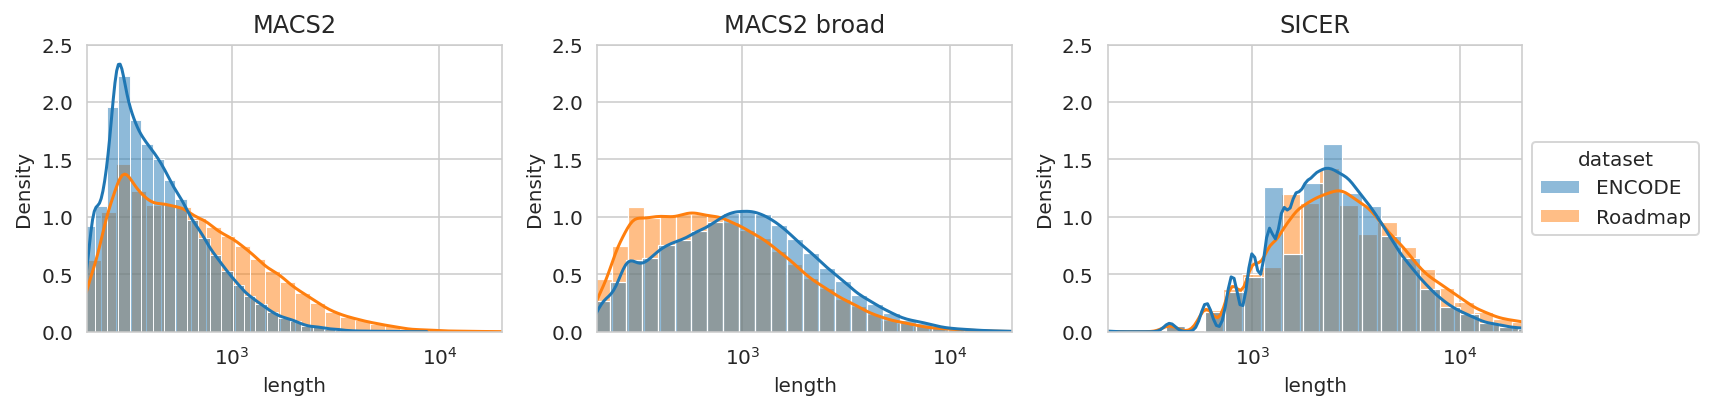

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


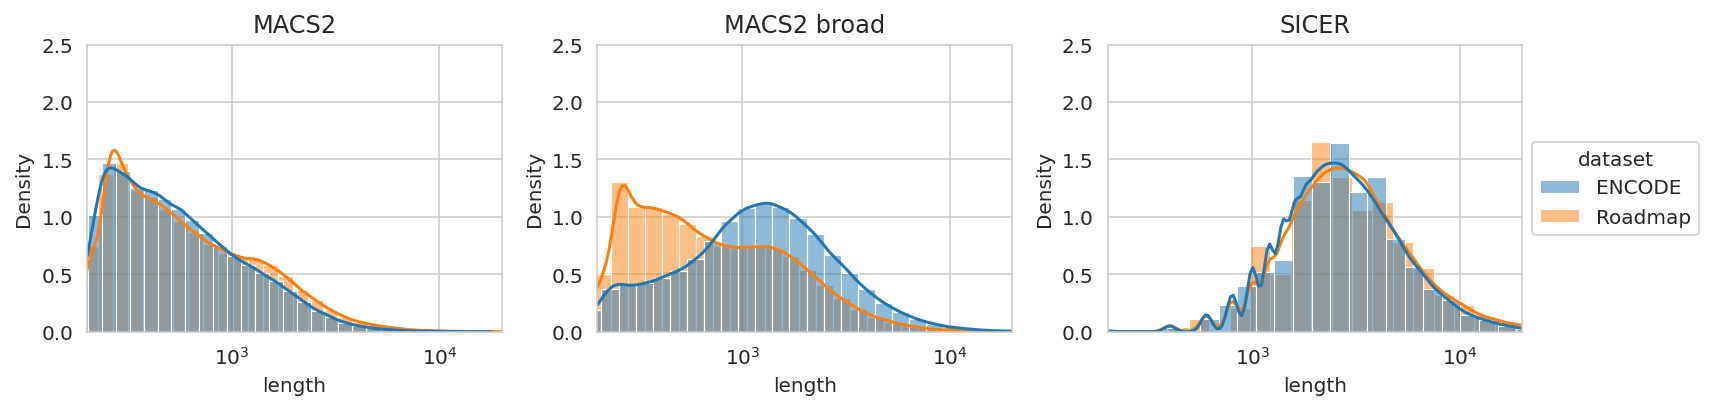

H3K36me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


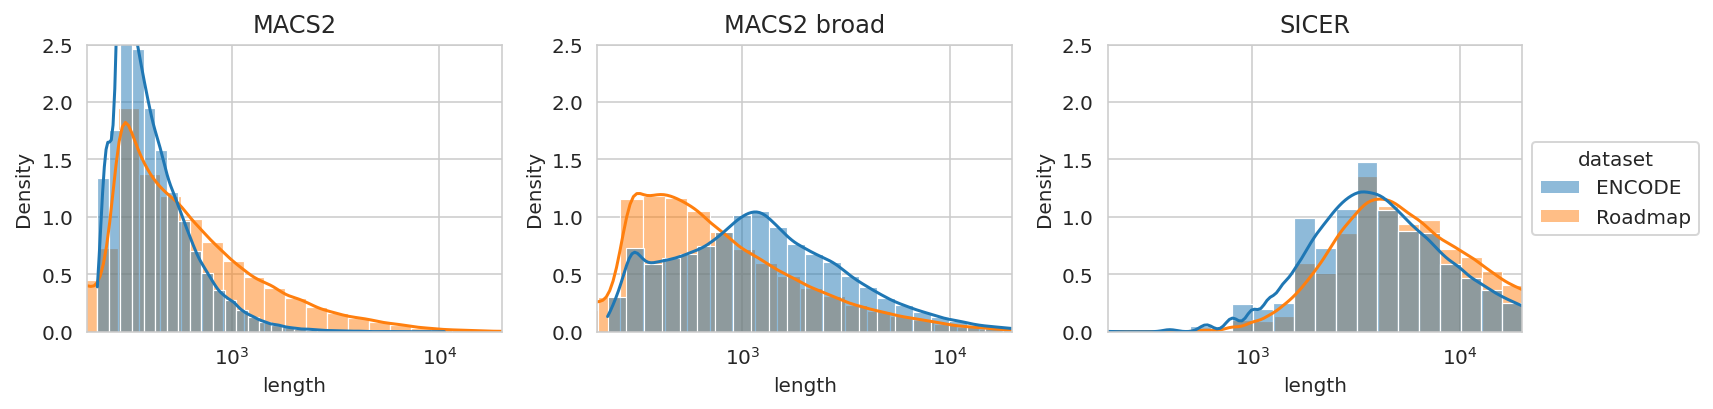

In [162]:
for m in ['H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='dataset', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 # palette=TOOLS_PALETTE,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K36me3


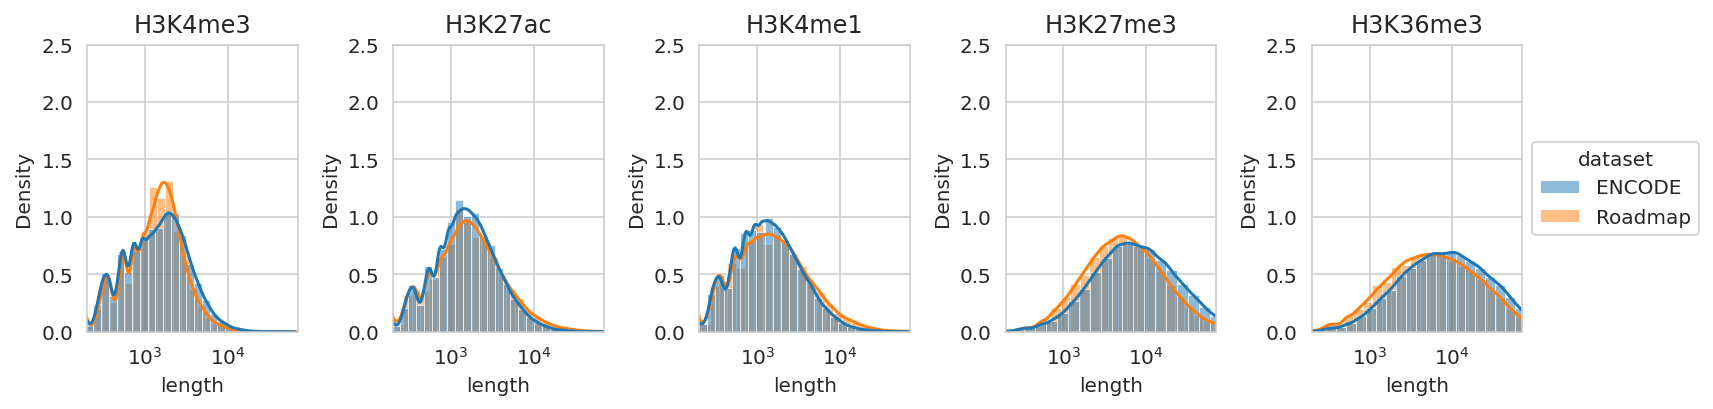

In [163]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # palette=TOOLS_PALETTE,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 7e4)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

In [164]:
t_aggr = t[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
t_aggr.sample(3)

dataset modification     cell replicate   tool     length
75   ENCODE     H3K27me3       H1      rep2   SPAN  4163.5135
236  ENCODE      H3K4me1     NHEK      rep1  SICER  3123.1400
252  ENCODE      H3K4me3  GM12878      rep1  SICER  3646.1400

H3K4me3
H3K27ac
H3K4me1
H3K36me3


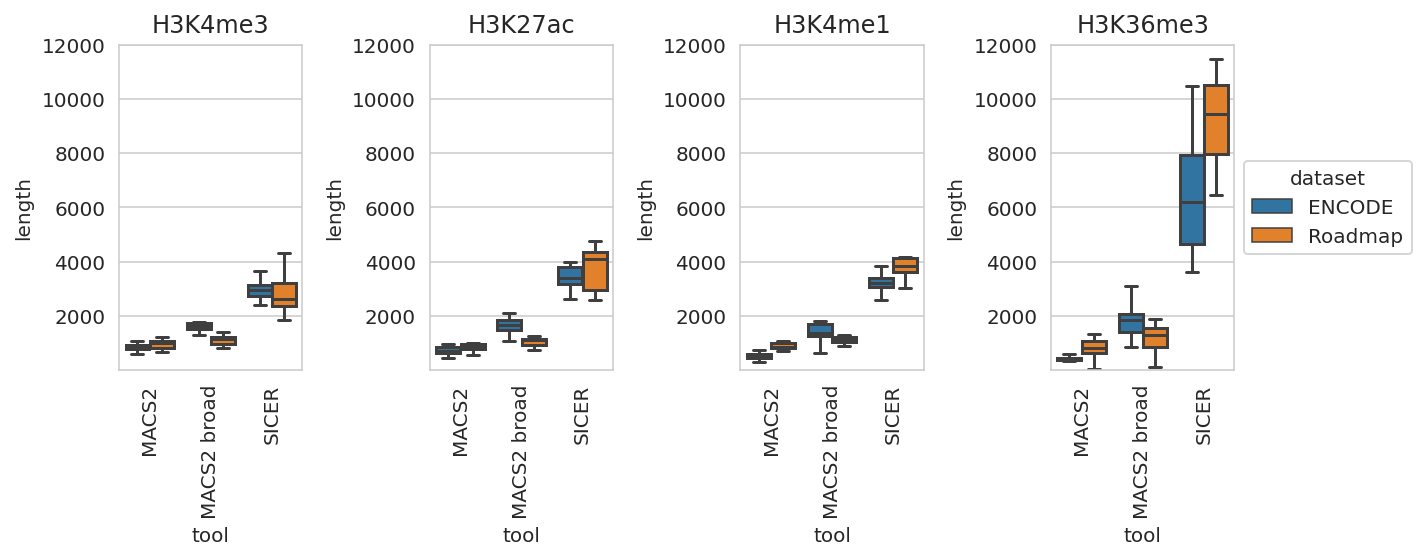

In [165]:
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.boxplot(data=t_aggr[t_aggr['modification'] == m],
                            x='tool', y='length', ax=ax, hue='dataset',
                            showfliers=False,
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            )
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(1, 1.2e4)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


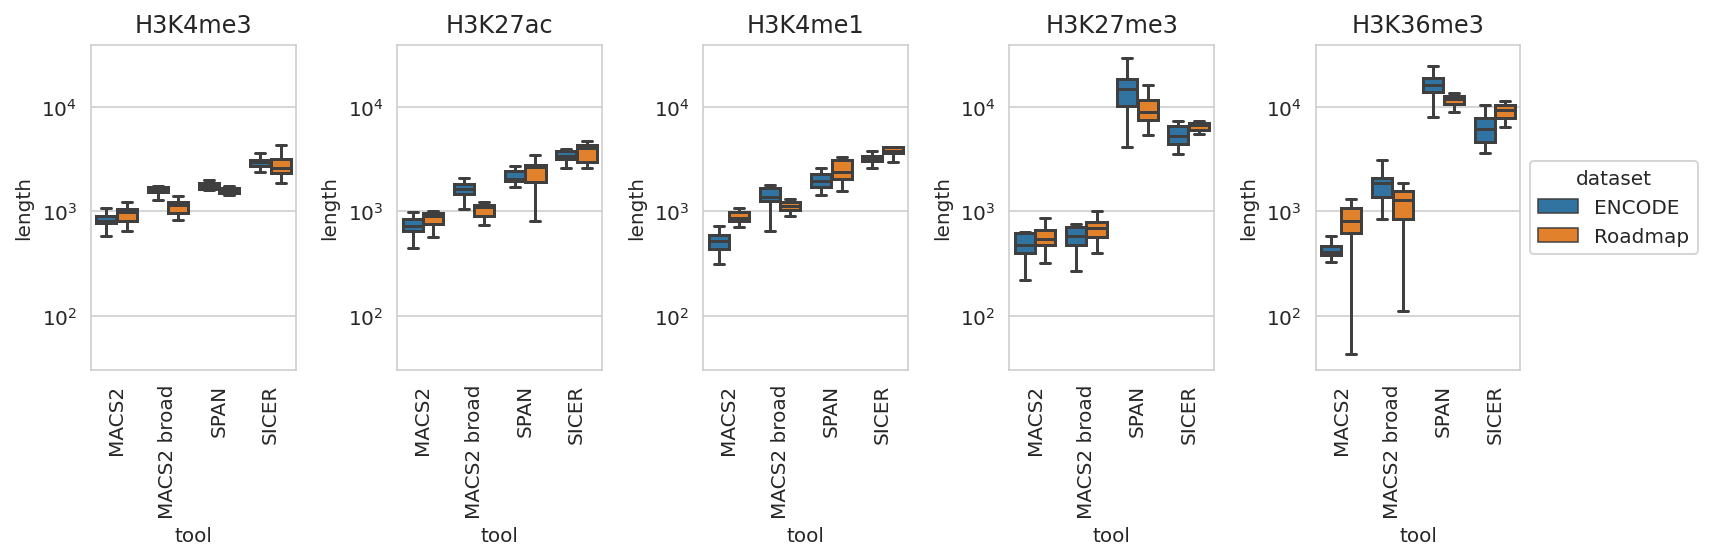

In [166]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.boxplot(data=t_aggr[t_aggr['modification'] == m],
                            x='tool', y='length', ax=ax, hue='dataset',
                            showfliers=False,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            )
    ax.title.set_text(m)
    ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(30, 4e4)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Difference

In [167]:
def compute_diffs(df, modifications, cells, replicates):
    tools = df['tool'].unique()
    rows = []    
    tf = tempfile.mktemp()
    for m, c, r in tqdm(list(product(modifications, cells, replicates))):
        print(m, c, r)
        t = df[(df['modification'] == m) & (df['cell'] == c) & (df['replicate'] == r) & (df['tool'] == 'SPAN')]
        if len(t) == 0:
            continue
        span_file = sorted_file(t['file'].values[0])
        # Processing single tools information
        for tool in tools:
            if tool == 'SPAN':
                continue
            t = df[(df['modification'] == m) & (df['cell'] == c) & (df['replicate'] == r) & (df['tool'] == tool)]
            if len(t) == 0:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            for name, args in [
                (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
                !bedtools intersect {args} -wa -v > {tf}
                peaks = lines(tf)
                rows.append((m, c, r, name, peaks))

    return pd.DataFrame(rows, columns=['modification', 'cell', 'replicate', 'name', 'peaks'])

## ENCODE

In [168]:
df_encode_diff = compute_diffs(df_encode_peaks, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_diff.sample(5)

  0%|          | 0/90 [00:00<?, ?it/s]

H3K4me3 GM12878 rep1
H3K4me3 GM12878 rep2
H3K4me3 HMEC rep1
H3K4me3 HMEC rep2
H3K4me3 HSMM rep1
H3K4me3 HSMM rep2
H3K4me3 K562 rep1
H3K4me3 K562 rep2
H3K4me3 NHEK rep1
H3K4me3 NHEK rep2
H3K4me3 NHLF rep1
H3K4me3 NHLF rep2
H3K4me3 H1 rep1
H3K4me3 H1 rep2
H3K4me3 Huvec rep1
H3K4me3 Huvec rep2
H3K4me3 HepG2 rep1
H3K4me3 HepG2 rep2
H3K27ac GM12878 rep1
H3K27ac GM12878 rep2
H3K27ac HMEC rep1
H3K27ac HMEC rep2
H3K27ac HSMM rep1
H3K27ac HSMM rep2
H3K27ac K562 rep1
H3K27ac K562 rep2
H3K27ac NHEK rep1
H3K27ac NHEK rep2
H3K27ac NHLF rep1
H3K27ac NHLF rep2
H3K27ac H1 rep1
H3K27ac H1 rep2
H3K27ac Huvec rep1
H3K27ac Huvec rep2
H3K27ac HepG2 rep1
H3K27ac HepG2 rep2
H3K4me1 GM12878 rep1
H3K4me1 GM12878 rep2
H3K4me1 HMEC rep1
H3K4me1 HMEC rep2
H3K4me1 HSMM rep1
H3K4me1 HSMM rep2
H3K4me1 K562 rep1
H3K4me1 K562 rep2
H3K4me1 NHEK rep1
H3K4me1 NHEK rep2
H3K4me1 NHLF rep1
H3K4me1 NHLF rep2
H3K4me1 H1 rep1
H3K4me1 H1 rep2
H3K4me1 Huvec rep1
H3K4me1 Huvec rep2
H3K4me1 HepG2 rep1
H3K4me1 HepG2 rep2
H3K27me3 G

modification     cell replicate                name  peaks
504     H3K36me3    HepG2      rep2        SPAN - MACS2  23041
357     H3K27me3     NHEK      rep2  MACS2 broad - SPAN   2409
222      H3K4me1     HSMM      rep1        SPAN - MACS2  32164
86       H3K4me3    Huvec      rep2  SPAN - MACS2 broad   9368
202      H3K4me1  GM12878      rep1        SPAN - SICER  16787

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


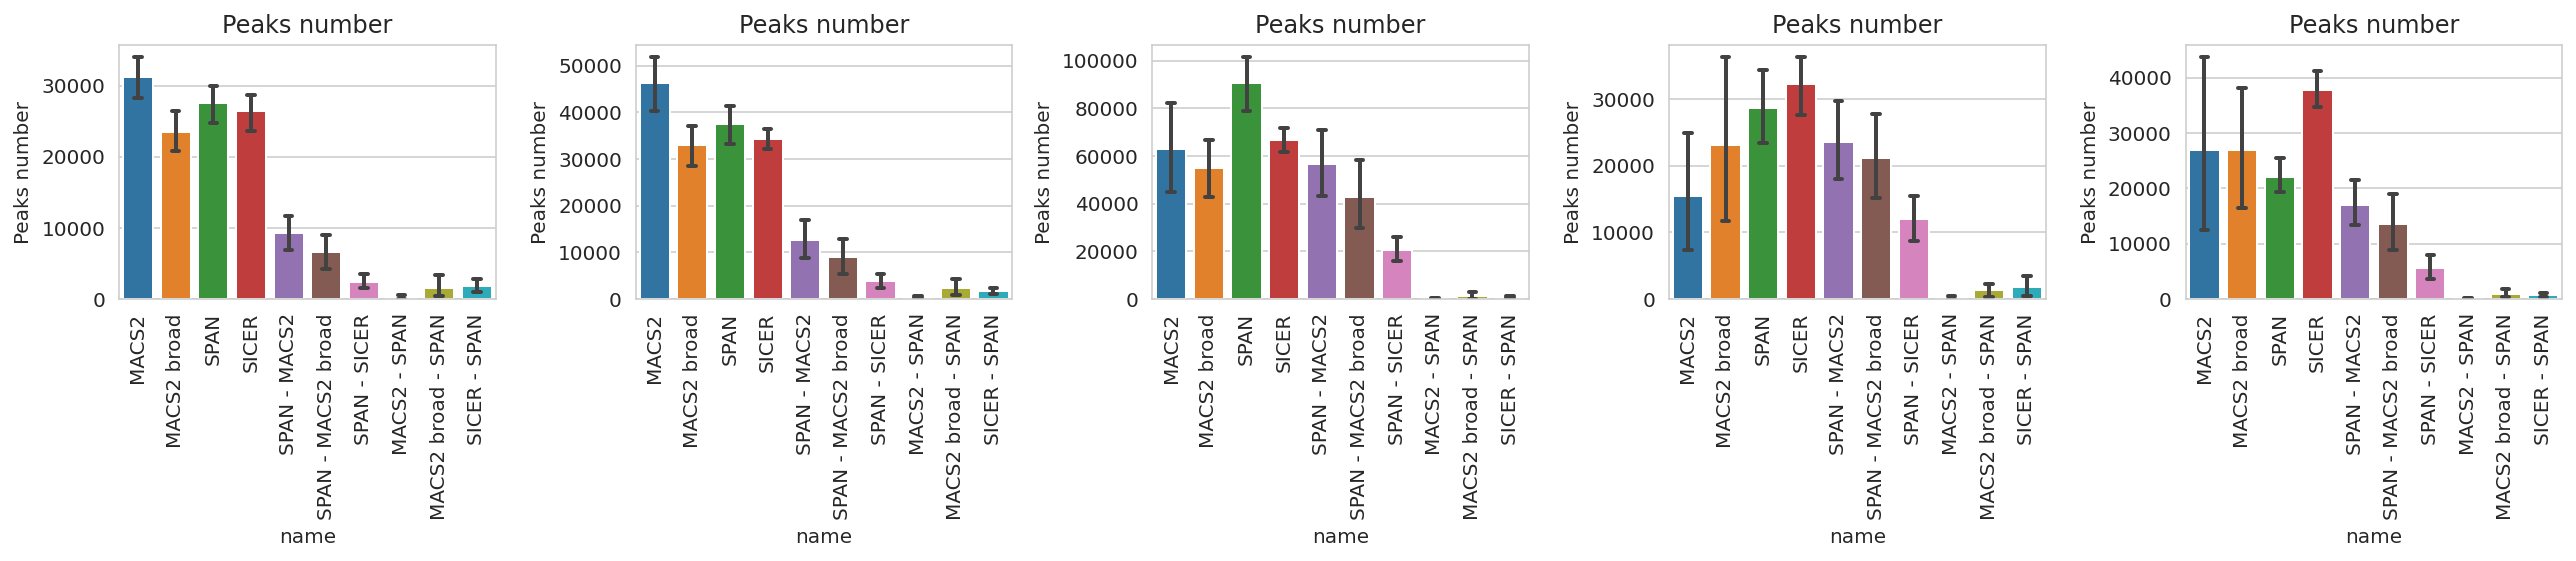

In [169]:
t = df_encode_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
t.rename({'tool': 'name'}, axis=1, inplace=True)
t = pd.concat([t, df_encode_diff]).reset_index(drop=True)

plt.figure(figsize=(18, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    print(m)
    ax.title.set_text('Peaks number')
    g_results = sns.barplot(data=t[t['modification'] == m], x='name', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

## Roadmap

In [170]:
df_immune_diff = compute_diffs(df_immune_peaks, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_diff.sample(5)

  0%|          | 0/180 [00:00<?, ?it/s]

H3K4me3 CD4ABT rep1
H3K4me3 CD4ABT rep2
H3K4me3 CD4ABT rep3
H3K4me3 CD4ABT 
H3K4me3 TCellBB rep1
H3K4me3 TCellBB rep2
H3K4me3 TCellBB rep3
H3K4me3 TCellBB 
H3K4me3 BCell rep1
H3K4me3 BCell rep2
H3K4me3 BCell rep3
H3K4me3 BCell 
H3K4me3 TCell rep1
H3K4me3 TCell rep2
H3K4me3 TCell rep3
H3K4me3 TCell 
H3K4me3 Monocyte rep1
H3K4me3 Monocyte rep2
H3K4me3 Monocyte rep3
H3K4me3 Monocyte 
H3K4me3 PBMC rep1
H3K4me3 PBMC rep2
H3K4me3 PBMC rep3
H3K4me3 PBMC 
H3K4me3 NK rep1
H3K4me3 NK rep2
H3K4me3 NK rep3
H3K4me3 NK 
H3K4me3 CD34 rep1
H3K4me3 CD34 rep2
H3K4me3 CD34 rep3
H3K4me3 CD34 
H3K4me3 CD4 rep1
H3K4me3 CD4 rep2
H3K4me3 CD4 rep3
H3K4me3 CD4 
H3K27ac CD4ABT rep1
H3K27ac CD4ABT rep2
H3K27ac CD4ABT rep3
H3K27ac CD4ABT 
H3K27ac TCellBB rep1
H3K27ac TCellBB rep2
H3K27ac TCellBB rep3
H3K27ac TCellBB 
H3K27ac BCell rep1
H3K27ac BCell rep2
H3K27ac BCell rep3
H3K27ac BCell 
H3K27ac TCell rep1
H3K27ac TCell rep2
H3K27ac TCell rep3
H3K27ac TCell 
H3K27ac Monocyte rep1
H3K27ac Monocyte rep2
H3K27ac Mono

modification   cell replicate          name  peaks
179     H3K27me3  BCell            SICER - SPAN      4
227     H3K27me3    CD4            SICER - SPAN     38
175     H3K27me3  BCell            MACS2 - SPAN    131
125      H3K27ac    CD4            SICER - SPAN    548
78       H3K27ac  TCell            SPAN - MACS2   5868

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


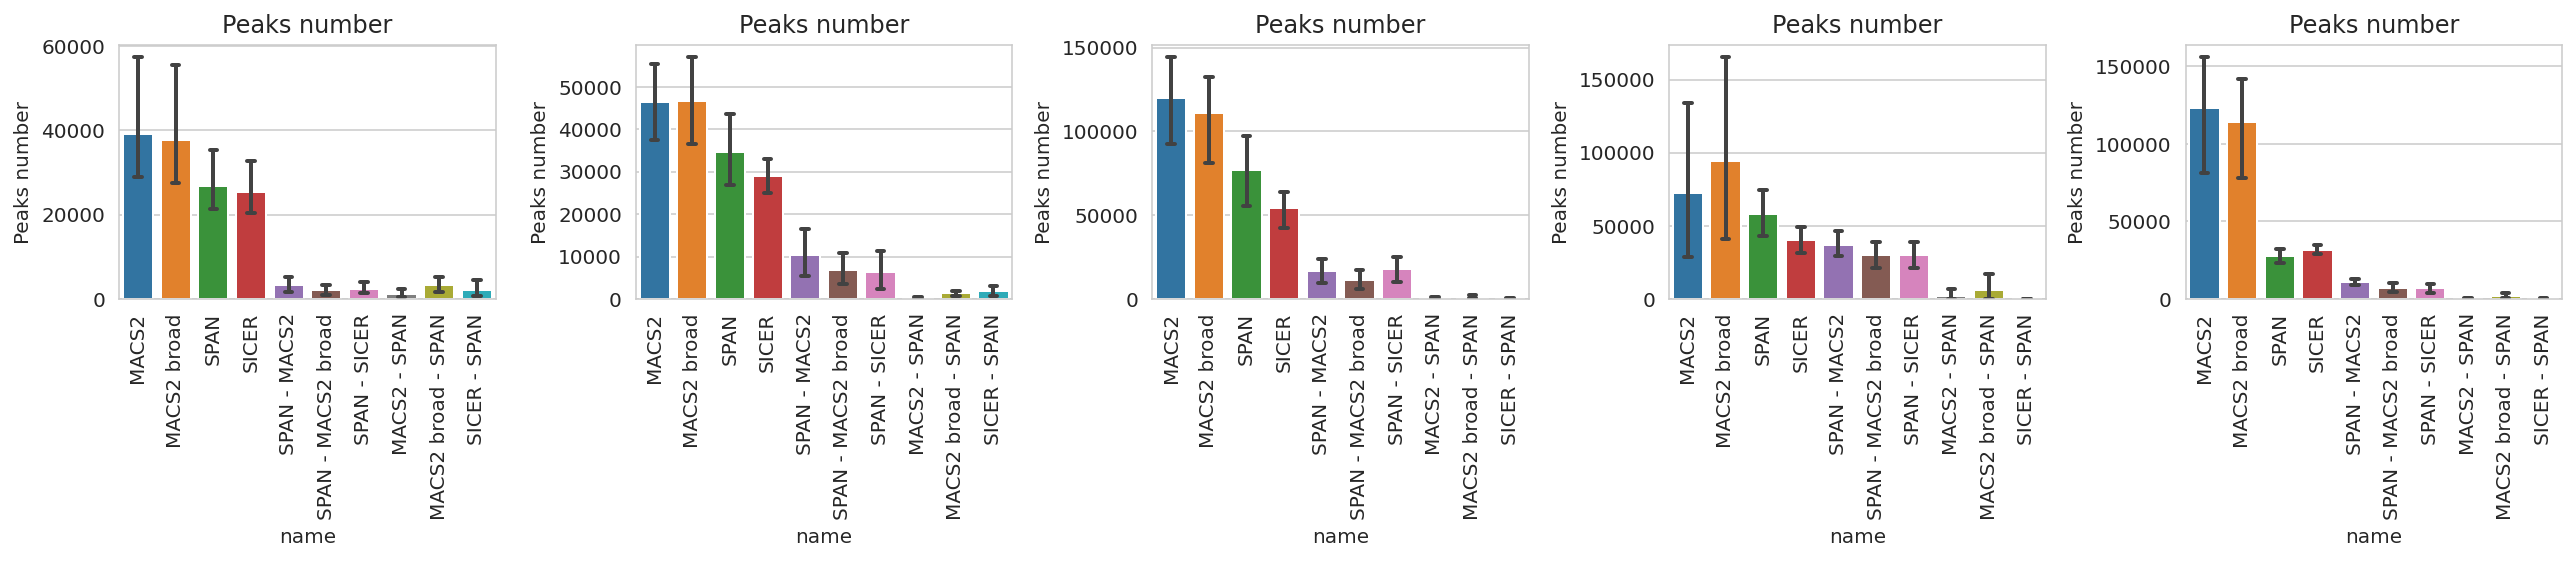

In [171]:
t = df_immune_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
t.rename({'tool': 'name'}, axis=1, inplace=True)
t = pd.concat([t, df_immune_diff]).reset_index(drop=True)

plt.figure(figsize=(18, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    ax.title.set_text('Peaks number')
    g_results = sns.barplot(data=t[t['modification'] == m], x='name', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

# Replicates

## Jaccard & Overlap

In [172]:
def compute_reps_overlap(df_peaks, modifications, cells):
    reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                     'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

    tf = tempfile.mktemp()

    tools = list(sorted(set(df_peaks['tool'])))
    for m, c in tqdm(product(modifications, cells)):
        print(m, c)
        tm = df_peaks[(df_peaks['modification'] == m) & (df_peaks['cell'] == c)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    file1 = sorted_file(t1['file'].values[0])
                    file2 = sorted_file(t2['file'].values[0])
                    peaks1 = t1['peaks'].values[0]
                    peaks1_len = int(bedl(file1).sum())
                    peaks2 = t2['peaks'].values[0]
                    peaks2_len = int(bedl(file2).sum())
                    !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                    overlap1 = lines(tf)
                    !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                    overlap2 = lines(tf)
                    !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                    overlap_len = int(last_col(tf).sum())

                    reps_overlap.loc[len(reps_overlap)] = \
                        (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                        overlap1, overlap2, overlap_len)
    reps_overlap['jaccard'] = [
        d(lo, l1 + l2 - lo)
        for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
    ]                    
    return reps_overlap

## Jaccard ENCODE 

In [173]:
t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS 
                         for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_encode_peaks
df_encode_reps = compute_reps_overlap(t, MODIFICATIONS, GSE26320_CELLS)
df_encode_reps.sample(5)

0it [00:00, ?it/s]

H3K4me3 GM12878
H3K4me3 HMEC
H3K4me3 HSMM
H3K4me3 K562
H3K4me3 NHEK
H3K4me3 NHLF
H3K4me3 H1
H3K4me3 Huvec
H3K4me3 HepG2
H3K27ac GM12878
H3K27ac HMEC
H3K27ac HSMM
H3K27ac K562
H3K27ac NHEK
H3K27ac NHLF
H3K27ac H1
H3K27ac Huvec
H3K27ac HepG2
H3K4me1 GM12878
H3K4me1 HMEC
H3K4me1 HSMM
H3K4me1 K562
H3K4me1 NHEK
H3K4me1 NHLF
H3K4me1 H1
H3K4me1 Huvec
H3K4me1 HepG2
H3K27me3 GM12878
H3K27me3 HMEC
H3K27me3 HSMM
H3K27me3 K562
H3K27me3 NHEK
H3K27me3 NHLF
H3K27me3 H1
H3K27me3 Huvec
H3K27me3 HepG2
H3K36me3 GM12878
H3K36me3 HMEC
H3K36me3 HSMM
H3K36me3 K562
H3K36me3 NHEK
H3K36me3 NHLF
H3K36me3 H1
H3K36me3 Huvec
H3K36me3 HepG2


modification     cell         tool  rep1  rep2  peaks1  peaks1_len  \
1        H3K4me3  GM12878  MACS2 broad  rep1  rep2   29024    58752715   
123     H3K36me3     K562         SPAN  rep1  rep2   17228   325039586   
83       H3K4me1     NHLF         SPAN  rep1  rep2   74118   145898700   
124     H3K36me3     NHLF        MACS2  rep1  rep2       3         979   
102     H3K27me3     NHEK        SICER  rep1  rep2   37724   199969276   

     peaks2  peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len  \
1     27319    57626660           22221           22039           45294289   
123   14572   328393451           13942           12466          276687676   
83    96487   204400462           60799           59154          113437727   
124  102587    56430656               0               0                  0   
102   37837   184272963           26041           26970          118765641   

      jaccard  
1    0.637184  
123  0.734416  
83   0.478920  
124  0.000000  
102  0.447368

ENCODE


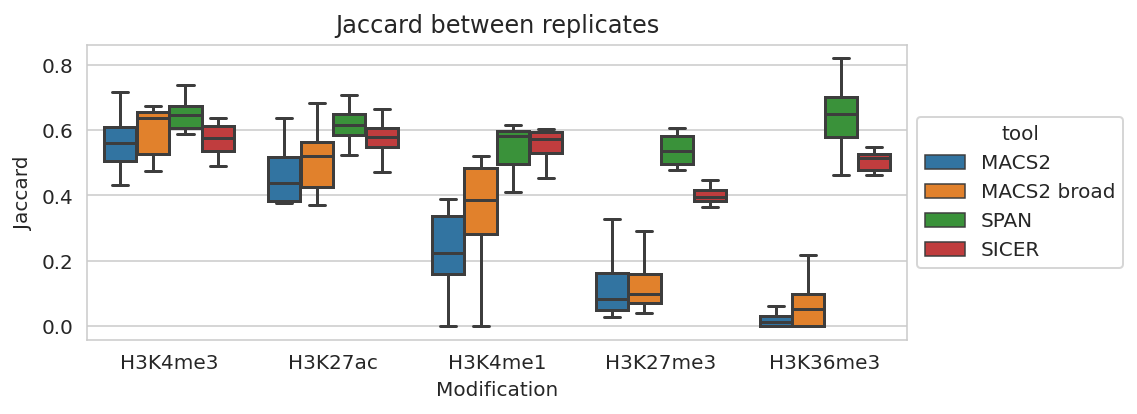

In [174]:
print('ENCODE')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False
                       )
ax = g_result.axes
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


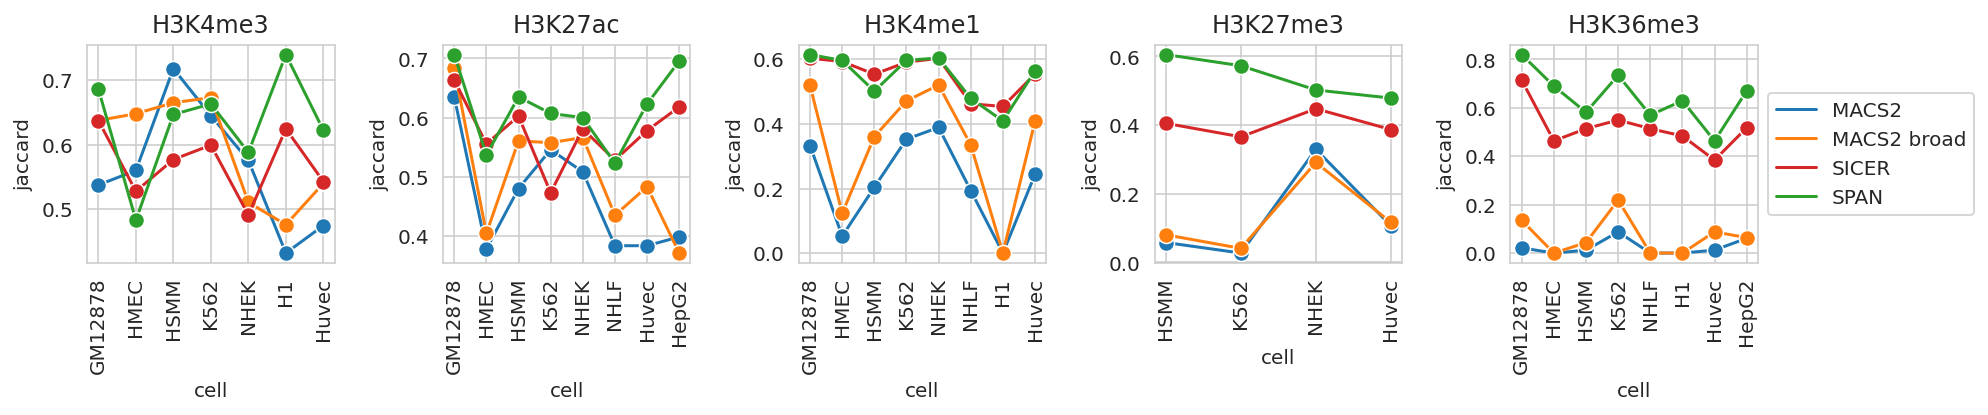

In [175]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

ENCODE


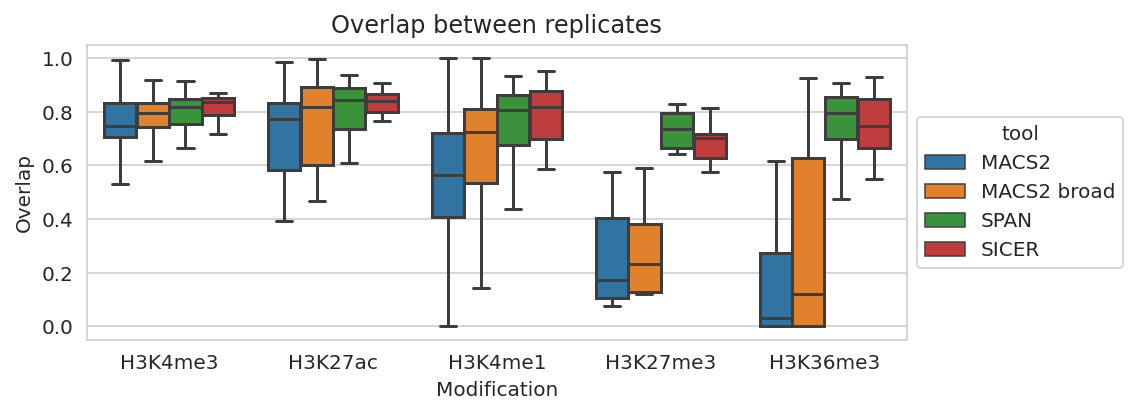

In [176]:
t = pd.concat([df_encode_reps[['modification', 'cell', 'tool']], 
               df_encode_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_encode_reps['peaks1_overlap'], df_encode_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_encode_reps['peaks2_overlap'], df_encode_reps['peaks2'])]
t['overlap'] = overlaps
print('ENCODE')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False
                       )
ax = g_result.axes
ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE
H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


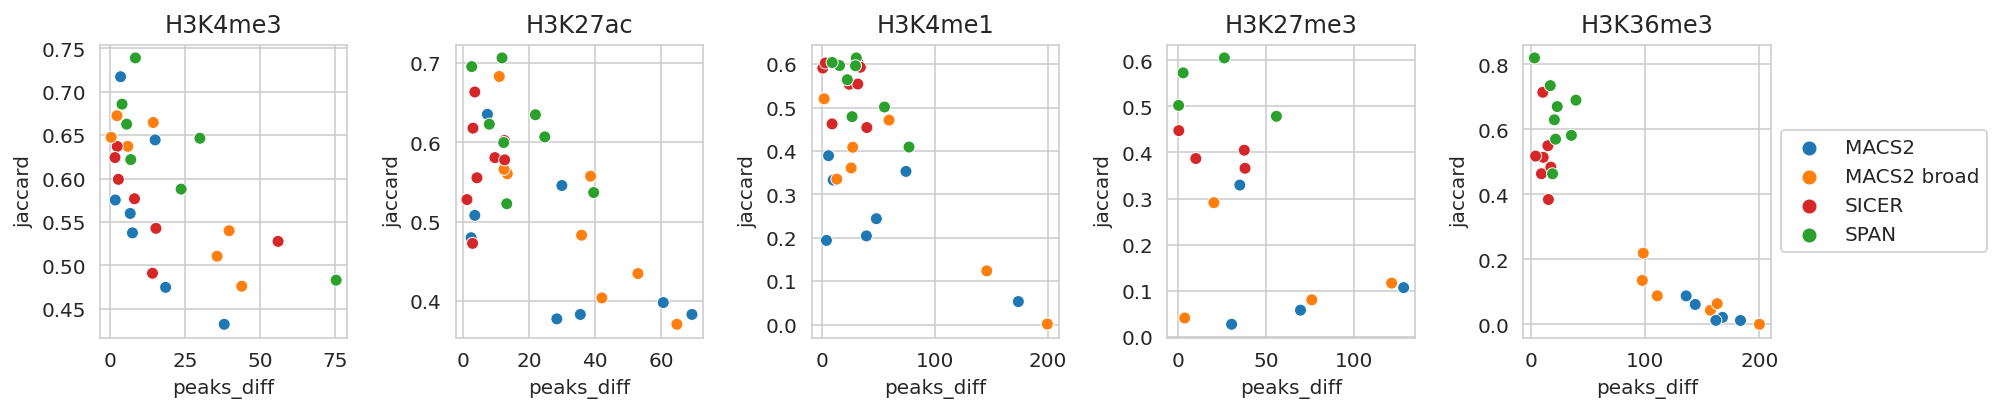

In [177]:
print('ENCODE')
df_encode_reps['peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                       (df_encode_reps['peaks1'] + df_encode_reps['peaks2']) * 200)
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                             x='peaks_diff', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [178]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_encode_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_encode = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

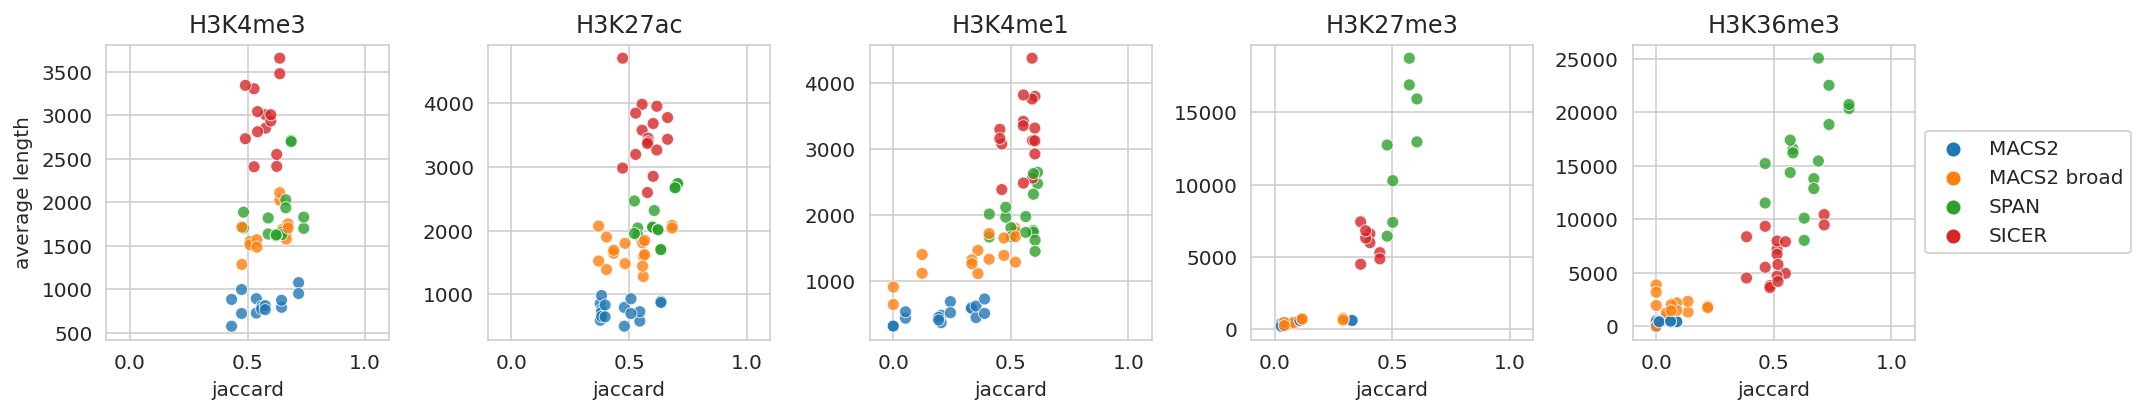

In [179]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax = ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K27ac


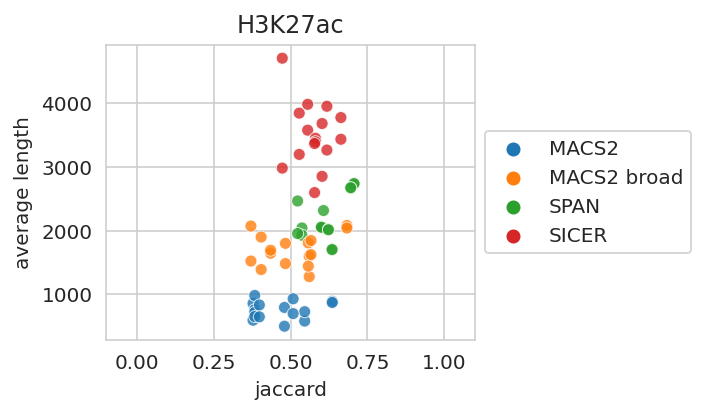

H3K4me1


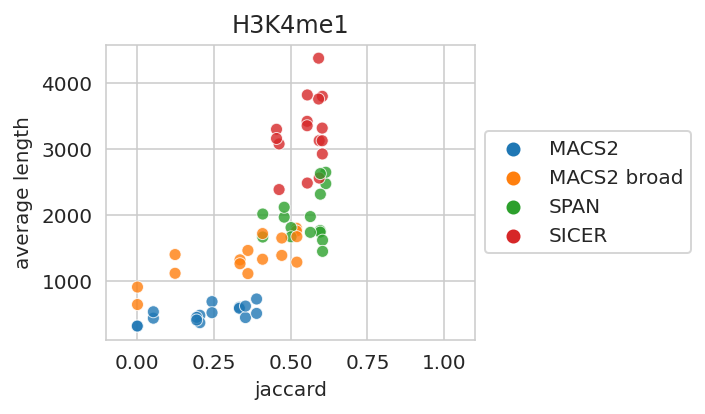

In [196]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax = ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    ax.set_ylabel('average length')
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

## Jaccard Roadmap

In [ ]:
t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS 
                         for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_immune_peaks
df_immune_reps = compute_reps_overlap(t, MODIFICATIONS, IMMUNE_CELLS)
df_immune_reps.sample(5)

0it [00:00, ?it/s]

H3K4me3 CD4ABT
H3K4me3 TCellBB
H3K4me3 BCell
H3K4me3 TCell
H3K4me3 Monocyte
H3K4me3 PBMC
H3K4me3 NK
H3K4me3 CD34
H3K4me3 CD4
H3K27ac CD4ABT
H3K27ac TCellBB
H3K27ac BCell
H3K27ac TCell
H3K27ac Monocyte
H3K27ac PBMC
H3K27ac NK
H3K27ac CD34
H3K27ac CD4
H3K4me1 CD4ABT
H3K4me1 TCellBB
H3K4me1 BCell
H3K4me1 TCell
H3K4me1 Monocyte
H3K4me1 PBMC
H3K4me1 NK
H3K4me1 CD34
H3K4me1 CD4
H3K27me3 CD4ABT
H3K27me3 TCellBB
H3K27me3 BCell
H3K27me3 TCell
H3K27me3 Monocyte
H3K27me3 PBMC
H3K27me3 NK
H3K27me3 CD34
H3K27me3 CD4
H3K36me3 CD4ABT
H3K36me3 TCellBB
H3K36me3 BCell
H3K36me3 TCell
H3K36me3 Monocyte
H3K36me3 PBMC
H3K36me3 NK
H3K36me3 CD34
H3K36me3 CD4


Immune


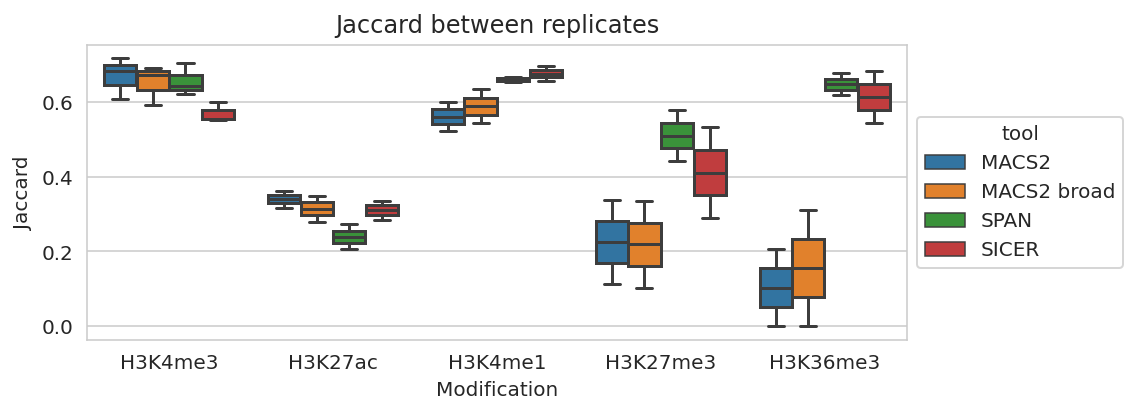

In [187]:
print('Immune')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       ) 
ax = g_result.axes
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


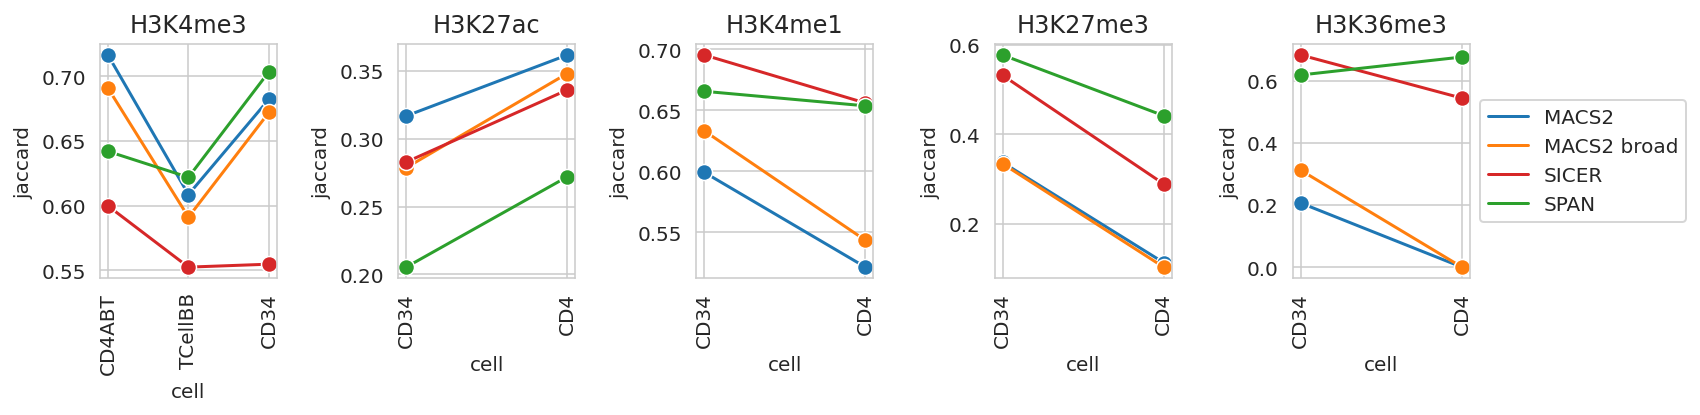

In [188]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

Immune


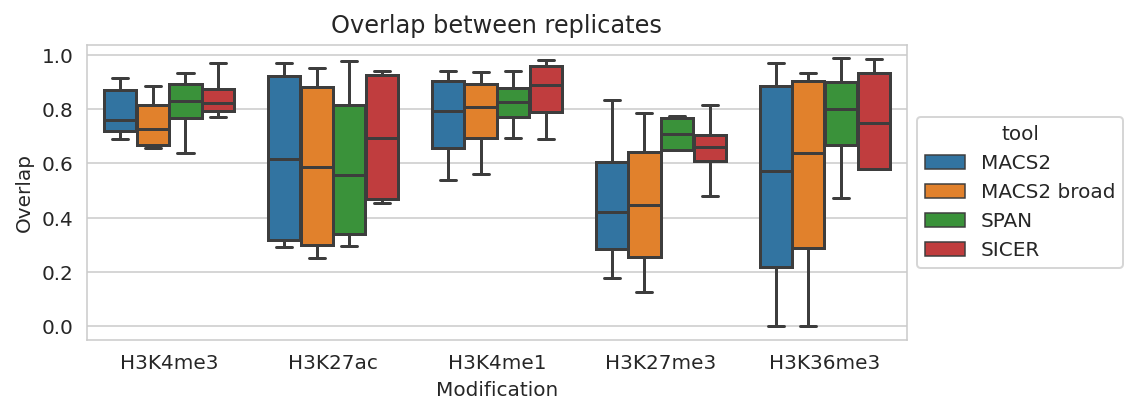

In [189]:
print('Immune')
t = pd.concat([df_immune_reps[['modification', 'cell', 'tool']],
               df_immune_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_immune_reps['peaks1_overlap'], df_immune_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_immune_reps['peaks2_overlap'], df_immune_reps['peaks2'])]
t['overlap'] = overlaps
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


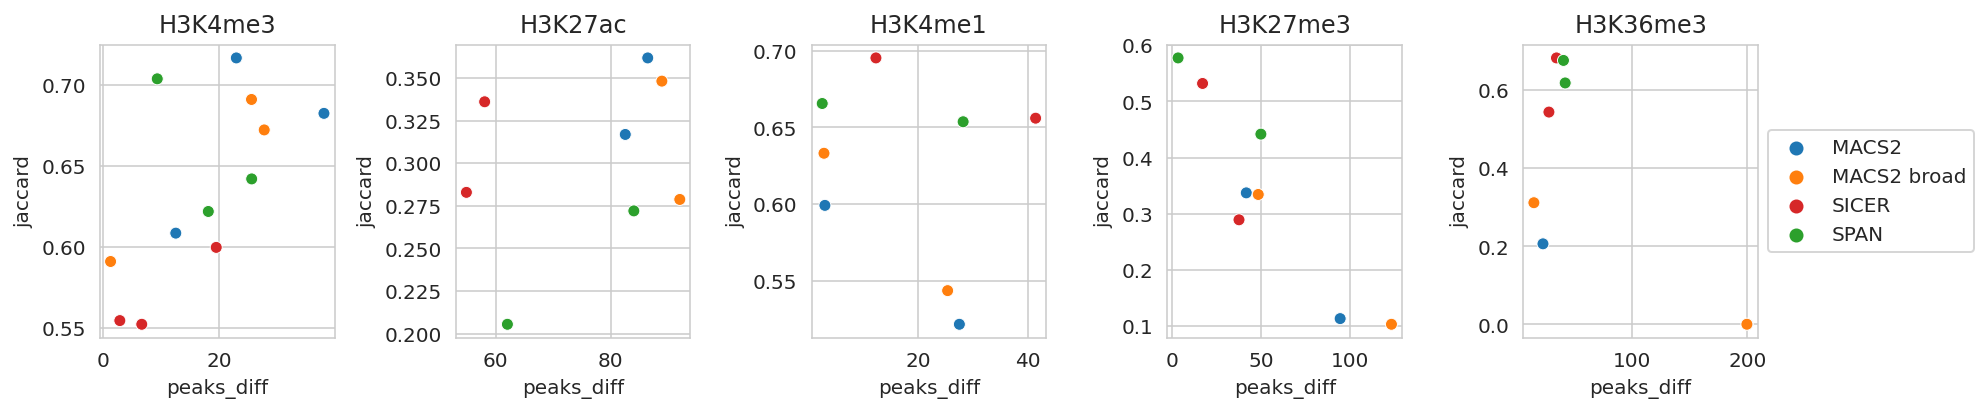

In [190]:
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) / 
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']) * 200)

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                                x='peaks_diff', y='jaccard', hue='tool',
                                hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                                palette=TOOLS_PALETTE,
                                ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [191]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_immune_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_immune = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

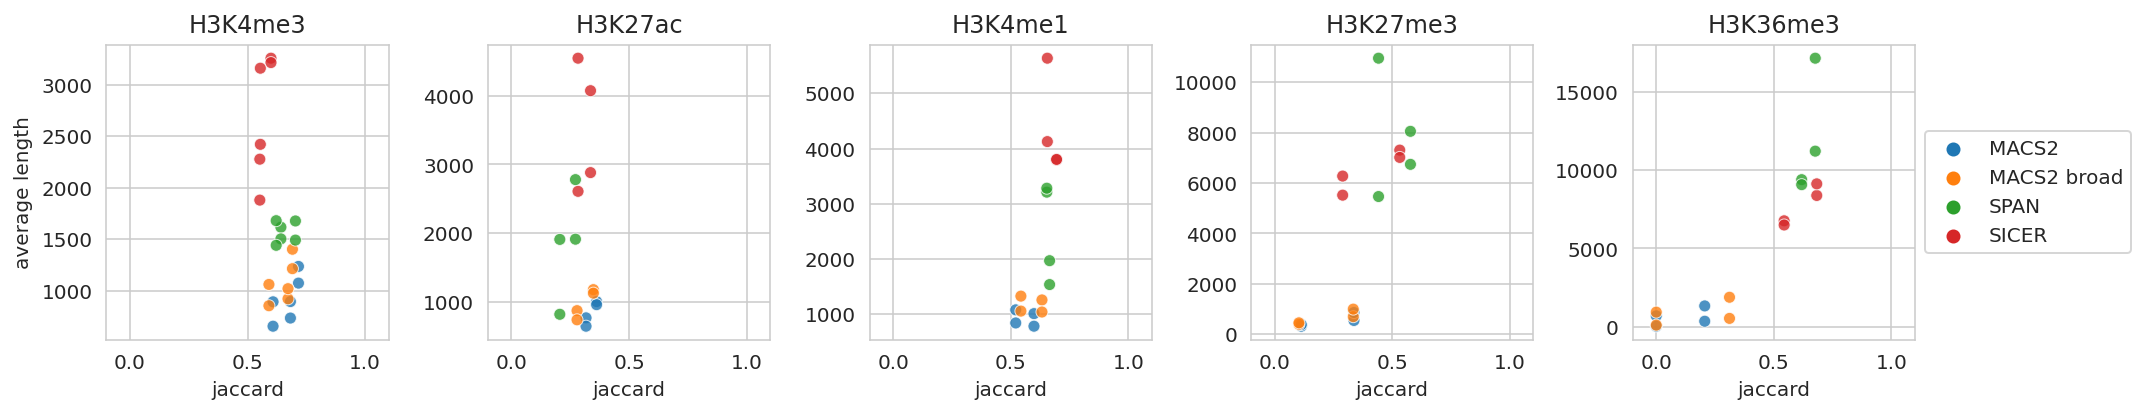

In [192]:

plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_immune[df_jaccard_avg_len_immune['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax = ax,
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
    #     Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## IDR

In [100]:
def compute_reps_idr(df_peaks, modifications, cells):
    reps_idr = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2', 'peaks1', 'peaks2', 
                                     'idr_loaded_peaks1', 'idr_loaded_peaks2', 'idr_peaks', 'idr_loaded_peaks', 'idr_percentage'
                                     ], dtype=object)

    tf = tempfile.mktemp()
    tf1 = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    tools = list(sorted(set(df_peaks['tool'])))
    for m, c in tqdm(list(product(modifications, cells))):
        print(m, c)
        tm = df_peaks[(df_peaks['modification'] == m) & (df_peaks['cell'] == c)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    try:
                        file1 = t1['file'].values[0]
                        file2 = t2['file'].values[0]
                        print(tool, file1, file2)
                        peaks1 = t1['peaks'].values[0]
                        peaks2 = t2['peaks'].values[0]
                        # Process SICER peaks, add missing 8th column, as -log10 qvalue
                        if tool == 'SICER':
                            sf1 = pd.read_csv(file1, sep='\t', header=None)
                            sf1[8] = -np.log10(sf1[7])
                            sf1.to_csv(tf1, sep='\t', index=None, header=False)
                            file1 = tf1
                            sf2 = pd.read_csv(file2, sep='\t', header=None)
                            sf2[8] = -np.log10(sf2[7])
                            sf2.to_csv(tf2, sep='\t', index=None, header=False)
                            file2 = tf2
                        ! idr --input-file-type bed --rank 8 --samples {file1} {file2} 2>&1 | tee {tf}
                        with open(tf) as f:
                            idr_out = f.read()
                        # print('IDR OUT', tf, idr_out)
                        lp1, lp2 = re.findall('Number of reported peaks - (\\d+)/(\\d+)', idr_out)[0]
                        lp1, lp2 = int(lp1), int(lp2)
                        ip, ilp, iperc = re.findall('Number of peaks passing IDR cutoff of 0.05 - (\\d+)/(\\d+) \\(([\\d\\.]+)', idr_out)[0]
                        ip, ilp, iperc = int(ip), int(ilp), float(iperc)
                        print(m, c, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                        reps_idr.loc[len(reps_idr)] = \
                            (m, c, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                    except Exception as e:
                        # raise e
                        # print(e)
                        pass  # Ignore errors for now
    return reps_idr

## IDR ENCODE

In [101]:
# t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
t = df_encode_peaks
df_encode_idr_reps = compute_reps_idr(t, MODIFICATIONS, GSE26320_CELLS)
df_encode_idr_reps.sample(5)

  0%|          | 0/45 [00:00<?, ?it/s]

H3K4me3 GM12878
MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646326_GM12878_H3K4me3_rep1_q0.05_peaks.narrowPeak /home/jetbrains/data/2023_GSE26320/macs2/GSM646327_GM12878_H3K4me3_rep2_q0.05_peaks.narrowPeak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [2.11 1.04 0.51 0.61]
Number of reported peaks - 23032/23032 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 13103/23032 (56.9%)

H3K4me3 GM12878 MACS2 rep1 rep2 41149 38141 23032 23032 13103 23032 56.9
MACS2 broad /home/jetbrains/data/2023_GSE26320/macs2/GSM646326_GM12878_H3K4me3_rep1_broad0.1_peaks.broadPeak /home/jetbrains/data/2023_GSE26320/macs2/GSM646327_GM12878_H3K4me3_rep2_broad0.1_peaks.broadPeak
/home/jetbrains/min

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.06 0.20 0.14 0.99]
Number of reported peaks - 142/142 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 90/142 (63.4%)

H3K4me3 GM12878 SICER rep1 rep2 32672 31862 142 142 90 142 63.4
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646326_GM12878_H3K4me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646327_GM12878_H3K4me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversi

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.00 0.92 0.10 0.01]
Number of reported peaks - 1883/1883 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1883 (0.0%)

H3K4me3 HMEC SICER rep1 rep2 25543 14360 1883 1883 0 1883 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646384_HMEC_H3K4me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646385_HMEC_H3K4me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
In

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.36 0.45 0.10 0.07]
Number of reported peaks - 1752/1752 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1752 (0.0%)

H3K4me3 HSMM SICER rep1 rep2 25813 23763 1752 1752 0 1752 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646404_HSMM_H3K4me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646405_HSMM_H3K4me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
In

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.00 0.87 0.10 0.02]
Number of reported peaks - 571/571 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/571 (0.0%)

H3K4me3 K562 SICER rep1 rep2 30206 29338 571 571 0 571 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646444_K562_H3K4me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646445_K562_H3K4me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial 

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.15 0.20 0.10 0.99]
Number of reported peaks - 102/102 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 86/102 (84.3%)

H3K4me3 NHEK SICER rep1 rep2 33494 29035 102 102 86 102 84.3
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646466_NHEK_H3K4me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646467_NHEK_H3K4me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Init

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.19 0.75 0.10 0.11]
Number of reported peaks - 588/588 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/588 (0.0%)

H3K4me3 H1 SICER rep1 rep2 24202 23777 588 588 0 588 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646345_H1_H3K4me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646346_H1_H3K4me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parame

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.42 0.78 0.11 0.01]
Number of reported peaks - 775/775 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/775 (0.0%)

H3K4me3 Huvec SICER rep1 rep2 24595 21074 775 775 0 775 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646424_Huvec_H3K4me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646425_Huvec_H3K4me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initi

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.45 0.46 0.10 0.03]
Number of reported peaks - 1425/1425 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1425 (0.0%)

H3K27ac GM12878 SICER rep1 rep2 32861 31704 1425 1425 0 1425 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646316_GM12878_H3K27ac_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646317_GM12878_H3K27ac_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxver

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.31 0.83 0.10 0.01]
Number of reported peaks - 745/745 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/745 (0.0%)

H3K27ac HMEC SICER rep1 rep2 36689 35171 745 745 0 745 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646374_HMEC_H3K27ac_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646375_HMEC_H3K27ac_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial 

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.10 0.62 0.10 0.99]
Number of reported peaks - 1282/1282 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 753/1282 (58.7%)

H3K27ac HSMM SICER rep1 rep2 36868 41796 1282 1282 753 1282 58.7
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646394_HSMM_H3K27ac_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646395_HSMM_H3K27ac_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversio

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.89 0.49 0.50 0.02]
Number of reported peaks - 1041/1041 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1041 (0.0%)

H3K27ac K562 SICER rep1 rep2 26929 26159 1041 1041 0 1041 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646434_K562_H3K27ac_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646435_K562_H3K27ac_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
In

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.26 0.74 0.10 0.01]
Number of reported peaks - 2311/2311 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/2311 (0.0%)

H3K27ac NHEK SICER rep1 rep2 40030 36343 2311 2311 0 2311 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646456_NHEK_H3K27ac_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646457_NHEK_H3K27ac_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
In

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.53 0.21 0.10 0.03]
Number of reported peaks - 691/691 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/691 (0.0%)

H3K27ac NHLF SICER rep1 rep2 38037 37580 691 691 0 691 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646476_NHLF_H3K27ac_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646477_NHLF_H3K27ac_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial 

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.25 0.85 0.10 0.22]
Number of reported peaks - 1215/1215 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1215 (0.0%)

H3K27ac Huvec SICER rep1 rep2 38747 34150 1215 1215 0 1215 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646414_Huvec_H3K27ac_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646415_Huvec_H3K27ac_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.00 0.92 0.10 0.07]
Number of reported peaks - 1895/1895 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1895 (0.0%)

H3K27ac HepG2 SICER rep1 rep2 28360 27516 1895 1895 0 1895 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646355_HepG2_H3K27ac_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646356_HepG2_H3K27ac_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.60 0.67 0.99 0.02]
Number of reported peaks - 166/166 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/166 (0.0%)

H3K4me1 GM12878 SICER rep1 rep2 70985 51620 166 166 0 166 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646322_GM12878_H3K4me1_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646323_GM12878_H3K4me1_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.21 0.20 0.97 0.05]
Number of reported peaks - 150/150 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/150 (0.0%)

H3K4me1 HMEC SICER rep1 rep2 69082 96949 150 150 0 150 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646380_HMEC_H3K4me1_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646381_HMEC_H3K4me1_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial 

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 13/13 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 13/13 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpukzzzsz1 /tmp/tmps_j8xy9r
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646400_HSMM_H3K4me1_rep1_200_0.05_0.peak /home/jet

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.08 0.26 0.10 0.99]
Number of reported peaks - 152/152 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 108/152 (71.1%)

H3K4me1 K562 SICER rep1 rep2 55839 55685 152 152 108 152 71.1
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646440_K562_H3K4me1_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646441_K562_H3K4me1_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
In

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.39 0.70 0.10 0.01]
Number of reported peaks - 241/241 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/241 (0.0%)

H3K4me1 NHEK SICER rep1 rep2 72654 70847 241 241 0 241 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646462_NHEK_H3K4me1_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646463_NHEK_H3K4me1_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial 

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.07 0.20 0.10 0.99]
Number of reported peaks - 33/33 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 23/33 (69.7%)

H3K4me1 NHLF SICER rep1 rep2 66313 72197 33 33 23 33 69.7
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646482_NHLF_H3K4me1_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646483_NHLF_H3K4me1_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial pa

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpukzzzsz1 /tmp/tmps_j8xy9r
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646341_H1_H3K4me1_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646342_H1_H3K4me1_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.21 0.84 0.10 0.01]
Number of reported peaks - 249/249 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/249 (0.0%)

H3K4me1 Huvec SICER rep1 rep2 51605 70741 249 249 0 249 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646420_Huvec_H3K4me1_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646421_Huvec_H3K4me1_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initi

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpukzzzsz1 /tmp/tmps_j8xy9r
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646318_GM12878_H3K27me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646319_GM12878_H3K27me3_rep2_200_0.05_0.peak
/home/jetbrains/mini

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 8/8 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 8/8 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpukzzzsz1 /tmp/tmps_j8xy9r
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646376_HMEC_H3K27me3_rep1_200_0.05_0.peak /home/jetbra

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 2/2 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 2/2 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpukzzzsz1 /tmp/tmps_j8xy9r
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646396_HSMM_H3K27me3_rep1_200_0.05_0.peak /home/jetbra

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 2/2 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 2/2 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpukzzzsz1 /tmp/tmps_j8xy9r
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646436_K562_H3K27me3_rep1_200_0.05_0.peak /home/jetbra

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.16 0.23 0.84 0.04]
Number of reported peaks - 239/239 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/239 (0.0%)

H3K27me3 NHEK SICER rep1 rep2 37724 37837 239 239 0 239 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646458_NHEK_H3K27me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646459_NHEK_H3K27me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initi

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.10 0.20 0.10 0.99]
Number of reported peaks - 27/27 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 22/27 (81.5%)

H3K27me3 NHLF SICER rep1 rep2 28080 38498 27 27 22 27 81.5
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646478_NHLF_H3K27me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646479_NHLF_H3K27me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.30 0.70 0.59 0.02]
Number of reported peaks - 550/550 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/550 (0.0%)

H3K27me3 H1 SICER rep1 rep2 10605 13713 550 550 0 550 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646337_H1_H3K27me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646338_H1_H3K27me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial par

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.25 0.58 0.10 0.01]
Number of reported peaks - 203/203 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/203 (0.0%)

H3K27me3 Huvec SICER rep1 rep2 36613 40452 203 203 0 203 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646416_Huvec_H3K27me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646417_Huvec_H3K27me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
In

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpukzzzsz1 /tmp/tmps_j8xy9r
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646357_HepG2_H3K27me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646358_HepG2_H3K27me3_rep2_200_0.05_0.peak
/home/jetbrains/minicond

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.01 0.35 0.13 0.18]
Number of reported peaks - 159/159 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/159 (0.0%)

H3K36me3 GM12878 SICER rep1 rep2 29804 33007 159 159 0 159 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646320_GM12878_H3K36me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646321_GM12878_H3K36me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversio

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 5/5 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 5/5 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpukzzzsz1 /tmp/tmps_j8xy9r
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646378_HMEC_H3K36me3_rep1_200_0.05_0.peak /home/jetbra

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.09 0.20 0.10 0.99]
Number of reported peaks - 50/50 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 37/50 (74.0%)

H3K36me3 HSMM SICER rep1 rep2 50627 45580 50 50 37 50 74.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646398_HSMM_H3K36me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646399_HSMM_H3K36me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.07 0.20 0.27 0.99]
Number of reported peaks - 32/32 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 22/32 (68.8%)

H3K36me3 K562 SICER rep1 rep2 34144 39540 32 32 22 32 68.8
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646438_K562_H3K36me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646439_K562_H3K36me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.09 0.24 0.10 0.10]
Number of reported peaks - 59/59 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/59 (0.0%)

H3K36me3 NHLF SICER rep1 rep2 44110 39699 59 59 0 59 0.0
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646480_NHLF_H3K36me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646481_NHLF_H3K36me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial par

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.07 0.20 0.10 0.99]
Number of reported peaks - 36/36 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 25/36 (69.4%)

H3K36me3 H1 SICER rep1 rep2 34574 29093 36 36 25 36 69.4
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646339_H1_H3K36me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646340_H1_H3K36me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial param

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 12/12 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 12/12 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpukzzzsz1 /tmp/tmps_j8xy9r
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646418_Huvec_H3K36me3_rep1_200_0.05_0.peak /home/j

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.08 0.20 0.10 0.99]
Number of reported peaks - 22/22 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 16/22 (72.7%)

H3K36me3 HepG2 SICER rep1 rep2 43335 41709 22 22 16 22 72.7
SPAN /home/jetbrains/data/2023_GSE26320/span/GSM646359_HepG2_H3K36me3_rep1_200_0.05_0.peak /home/jetbrains/data/2023_GSE26320/span/GSM646360_HepG2_H3K36me3_rep2_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Init

modification     cell   tool  rep1  rep2  peaks1  peaks2  \
63       H3K4me1  GM12878   SPAN  rep1  rep2   84659   62604   
2        H3K4me3  GM12878  SICER  rep1  rep2   32672   31862   
128     H3K36me3     K562   SPAN  rep1  rep2   17228   14572   
34       H3K27ac     HMEC  SICER  rep1  rep2   36689   35171   
3        H3K4me3  GM12878   SPAN  rep1  rep2   33045   31709   

     idr_loaded_peaks1  idr_loaded_peaks2  idr_peaks  idr_loaded_peaks  \
63               53325              53325      19567             53325   
2                  142                142         90               142   
128              10621              10621       7564             10621   
34                 745                745          0               745   
3                25736              25736      15745             25736   

     idr_percentage  
63             36.7  
2              63.4  
128            71.2  
34              0.0  
3              61.2

ENCODE


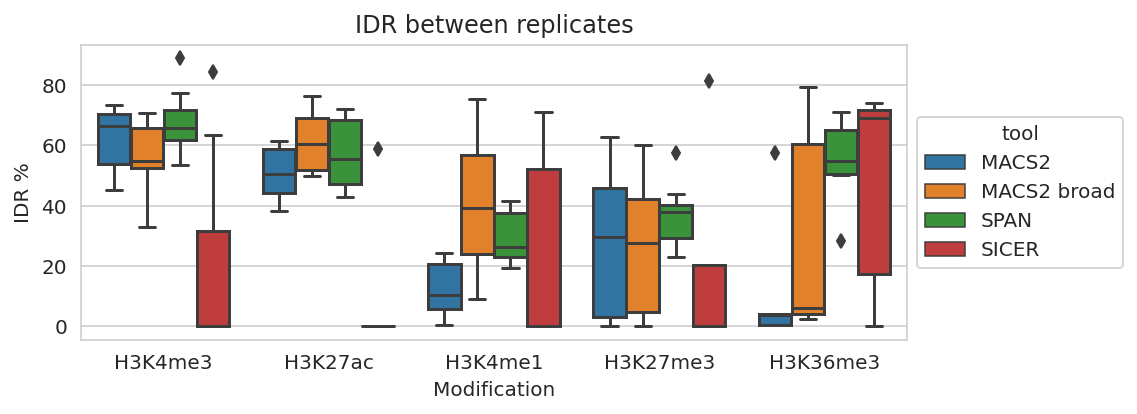

In [102]:
print('ENCODE')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_percentage',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR %')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

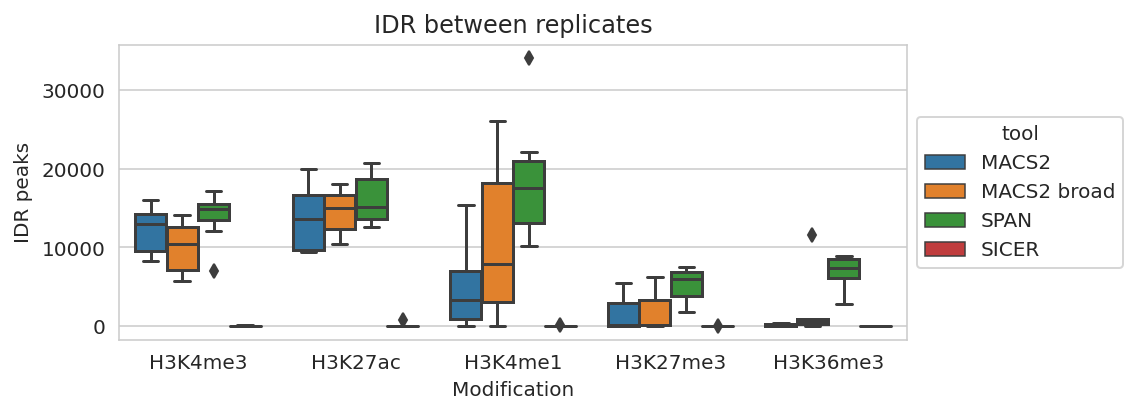

In [103]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

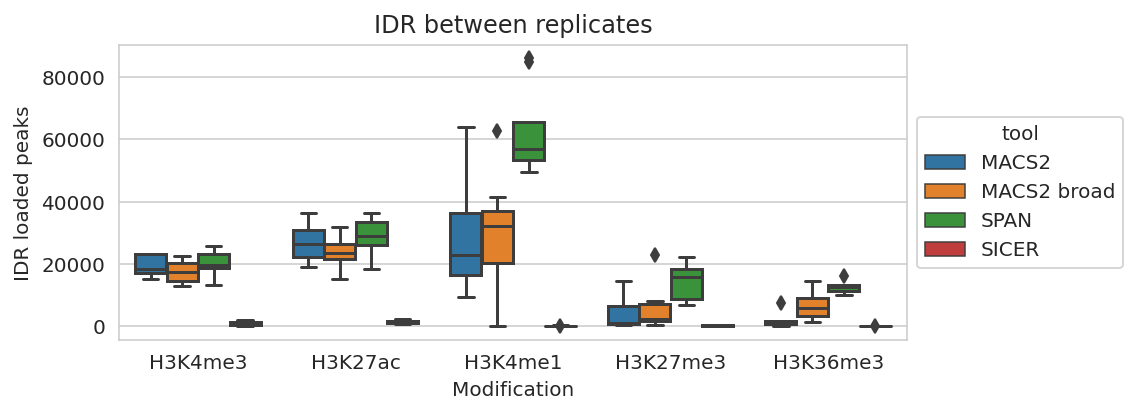

In [104]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_loaded_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR loaded peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

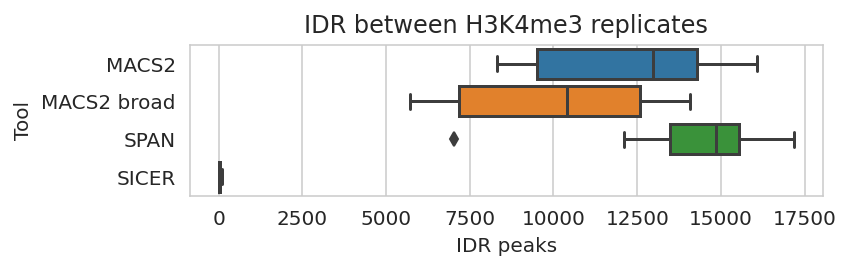

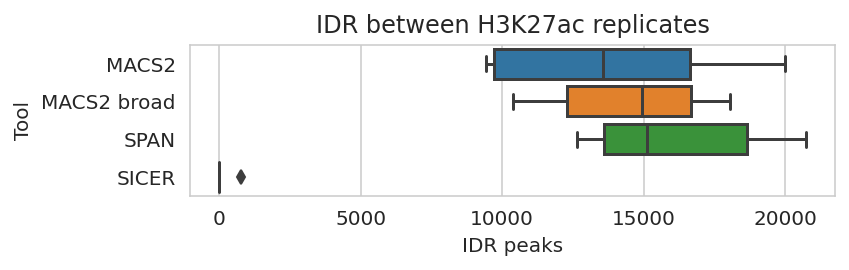

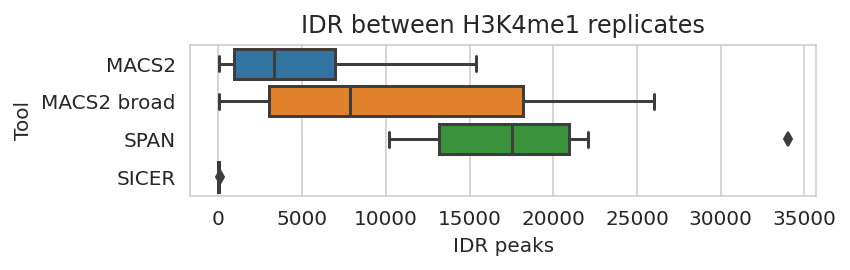

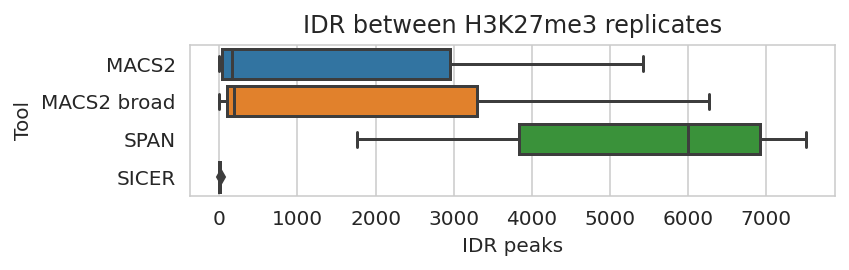

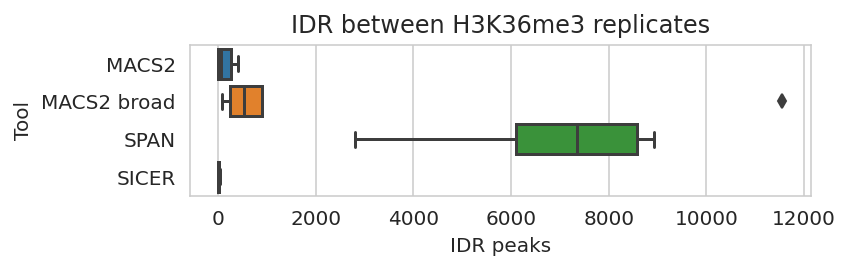

In [105]:
for m in MODIFICATIONS:
    plt.figure(figsize=(6, 2))
    g_result = sns.boxplot(data=df_encode_idr_reps[df_encode_idr_reps['modification'] == m], 
                           x='idr_peaks', y = 'tool',
                           palette=TOOLS_PALETTE,
                           order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                           )
    ax = g_result.axes
    ax.set_title(f'IDR between {m} replicates')
    ax.set_ylabel('Tool')
    ax.set_xlabel('IDR peaks')
    plt.tight_layout()
    plt.show()

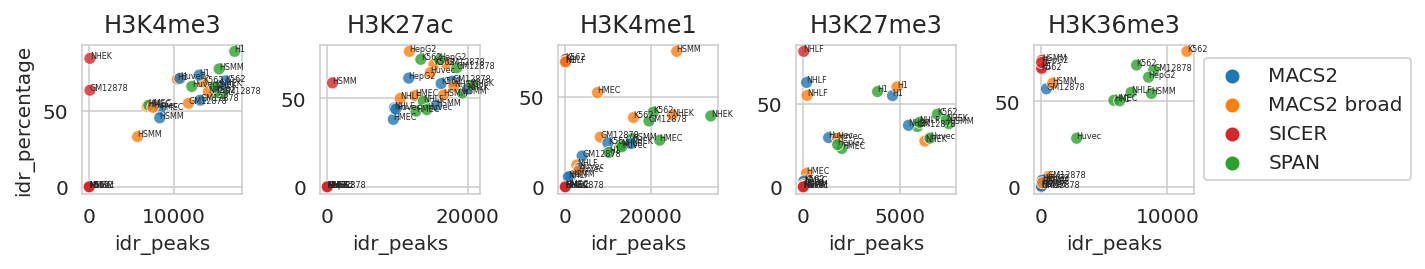

In [106]:
plt.figure(figsize=(10, 2))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_encode_idr_reps[df_encode_idr_reps['modification'] == m]
    g_results = sns.scatterplot(data=t,
                                x='idr_peaks', y='idr_percentage',
                                hue='tool',
                                palette=TOOLS_PALETTE,
                                alpha=0.8,
                                ax=ax,
                                )
    for x, y, cell in zip(t['idr_peaks'], t['idr_percentage'], t['cell']):
        ax.text(x, y, cell, fontsize = 4)
    ax.title.set_text(m)
    if i != 0:
        ax.set_ylabel(None)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

## IDR Roadmap

In [107]:
# t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
t = df_immune_peaks
df_immune_idr_reps = compute_reps_idr(t, MODIFICATIONS, IMMUNE_CELLS)
df_immune_idr_reps.sample(5)

  0%|          | 0/45 [00:00<?, ?it/s]

H3K4me3 CD4ABT
MACS2 /home/jetbrains/data/2023_Immune/macs2/CD4ABT_H3K4me3_rep1_hg38_ENCFF783BBS_q0.05_peaks.narrowPeak /home/jetbrains/data/2023_Immune/macs2/CD4ABT_H3K4me3_rep2_hg38_ENCFF480QOG_q0.05_peaks.narrowPeak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.45 0.20 0.83 0.67]
Number of reported peaks - 21043/21043 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 14603/21043 (69.4%)

H3K4me3 CD4ABT MACS2 rep1 rep2 25997 32717 21043 21043 14603 21043 69.4
MACS2 broad /home/jetbrains/data/2023_Immune/macs2/CD4ABT_H3K4me3_rep1_hg38_ENCFF783BBS_broad0.1_peaks.broadPeak /home/jetbrains/data/2023_Immune/macs2/CD4ABT_H3K4me3_rep2_hg38_ENCFF480QOG_broad0.1_peaks.broadPeak
/home

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.00 0.82 0.10 0.01]
Number of reported peaks - 2970/2970 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/2970 (0.0%)

H3K4me3 CD4ABT SICER rep1 rep2 19145 23270 2970 2970 0 2970 0.0
SPAN /home/jetbrains/data/2023_Immune/span/CD4ABT_H3K4me3_rep1_hg38_ENCFF783BBS_200_0.05_0.peak /home/jetbrains/data/2023_Immune/span/CD4ABT_H3K4me3_rep2_hg38_ENCFF480QOG_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.06 0.20 0.10 0.99]
Number of reported peaks - 149/149 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 98/149 (65.8%)

H3K4me3 TCellBB SICER rep1 rep2 31721 29667 149 149 98 149 65.8
SPAN /home/jetbrains/data/2023_Immune/span/TCellBB_H3K4me3_rep1_hg38_ENCFF167PUH_200_0.05_0.peak /home/jetbrains/data/2023_Immune/span/TCellBB_H3K4me3_rep2_hg38_ENCFF822TCP_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{n

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.02 0.93 0.10 0.49]
Number of reported peaks - 2435/2435 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/2435 (0.0%)

H3K4me3 CD34 SICER  rep2 20673 20075 2435 2435 0 2435 0.0
SPAN /home/jetbrains/data/2023_Immune/span/CD34_H3K4me3_hg38_ENCFF850YUJ_200_0.05_0.peak /home/jetbrains/data/2023_Immune/span/CD34_H3K4me3_rep2_hg38_ENCFF333HJE_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
I

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.73 0.47 0.13 0.01]
Number of reported peaks - 839/839 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/839 (0.0%)

H3K27ac CD34 SICER  rep2 37371 21276 839 839 0 839 0.0
SPAN /home/jetbrains/data/2023_Immune/span/CD34_H3K27ac_hg38_ENCFF026YFQ_200_0.05_0.peak /home/jetbrains/data/2023_Immune/span/CD34_H3K27ac_rep2_hg38_ENCFF821FUR_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.02 0.58 0.10 0.99]
Number of reported peaks - 840/840 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 431/840 (51.3%)

H3K27ac CD4 SICER  rep1 37659 20712 840 840 431 840 51.3
SPAN /home/jetbrains/data/2023_Immune/span/CD4_H3K27ac_hg38_ENCFF184ULC_200_0.05_0.peak /home/jetbrains/data/2023_Immune/span/CD4_H3K27ac_rep1_hg38_ENCFF732DAD_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Init

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.17 0.41 0.66 0.02]
Number of reported peaks - 906/906 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/906 (0.0%)

H3K4me1 CD34 SICER  rep2 69882 61712 906 906 0 906 0.0
SPAN /home/jetbrains/data/2023_Immune/span/CD34_H3K4me1_hg38_ENCFF209GBB_200_0.05_0.peak /home/jetbrains/data/2023_Immune/span/CD34_H3K4me1_rep2_hg38_ENCFF524TPM_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.27 0.90 0.10 0.01]
Number of reported peaks - 857/857 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/857 (0.0%)

H3K4me1 CD4 SICER  rep1 58199 38267 857 857 0 857 0.0
SPAN /home/jetbrains/data/2023_Immune/span/CD4_H3K4me1_hg38_ENCFF084RYS_200_0.05_0.peak /home/jetbrains/data/2023_Immune/span/CD4_H3K4me1_rep1_hg38_ENCFF033IYM_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial pa

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.28 0.56 0.10 0.02]
Number of reported peaks - 405/405 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/405 (0.0%)

H3K27me3 CD34 SICER  rep2 30576 36287 405 405 0 405 0.0
SPAN /home/jetbrains/data/2023_Immune/span/CD34_H3K27me3_hg38_ENCFF987YGU_200_0.05_0.peak /home/jetbrains/data/2023_Immune/span/CD34_H3K27me3_rep2_hg38_ENCFF198XDU_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Init

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 8/8 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 8/8 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpuhjenisi /tmp/tmpfaq5gnox
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SPAN /home/jetbrains/data/2023_Immune/span/CD4_H3K27me3_hg38_ENCFF408ABL_200_0.05_0.peak /home/jetbrai

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.59 0.70 0.51 0.01]
Number of reported peaks - 675/675 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/675 (0.0%)

H3K36me3 CD34 SICER  rep1 38823 27445 675 675 0 675 0.0
SPAN /home/jetbrains/data/2023_Immune/span/CD34_H3K36me3_hg38_ENCFF924KBL_200_0.05_0.peak /home/jetbrains/data/2023_Immune/span/CD34_H3K36me3_rep1_hg38_ENCFF785IJG_200_0.05_0.peak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Init

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 6/6 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 6/6 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpuhjenisi /tmp/tmpfaq5gnox
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SPAN /home/jetbrains/data/2023_Immune/span/CD4_H3K36me3_hg38_ENCFF489CFC_200_0.05_0.peak /home/jetbrai

modification  cell         tool rep1  rep2  peaks1  peaks2  \
13      H3K27ac  CD34  MACS2 broad       rep2   79969   29558   
27      H3K4me1   CD4         SPAN       rep1   69107   52026   
14      H3K27ac  CD34        SICER       rep2   37371   21276   
34     H3K27me3   CD4         SPAN       rep2   40966   68235   
33     H3K27me3   CD4  MACS2 broad       rep2    5166   21849   

    idr_loaded_peaks1  idr_loaded_peaks2  idr_peaks  idr_loaded_peaks  \
13              19608              19608      12776             19608   
27              43625              43625      27700             43625   
14                839                839          0               839   
34              28959              28959      11888             28959   
33               2605               2605        148              2605   

    idr_percentage  
13            65.2  
27            63.5  
14             0.0  
34            41.1  
33             5.7

Immune


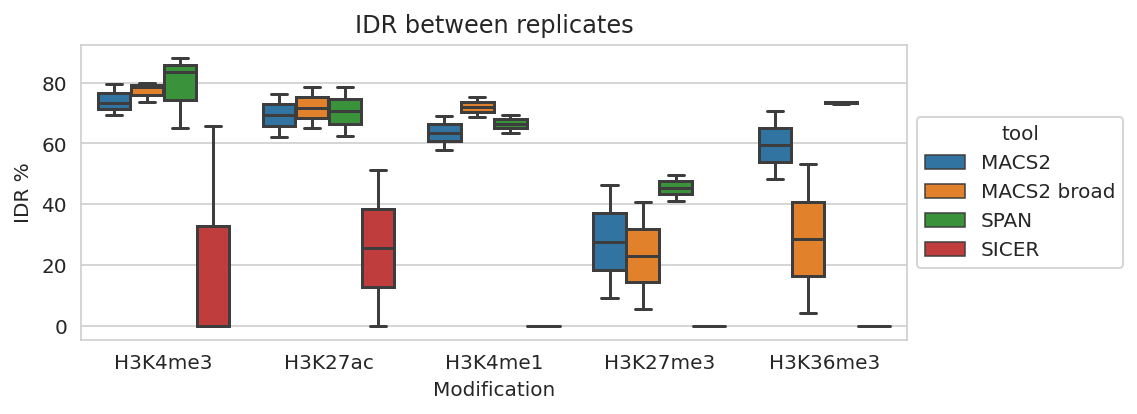

In [108]:
print('Immune')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_percentage',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR %')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

Immune


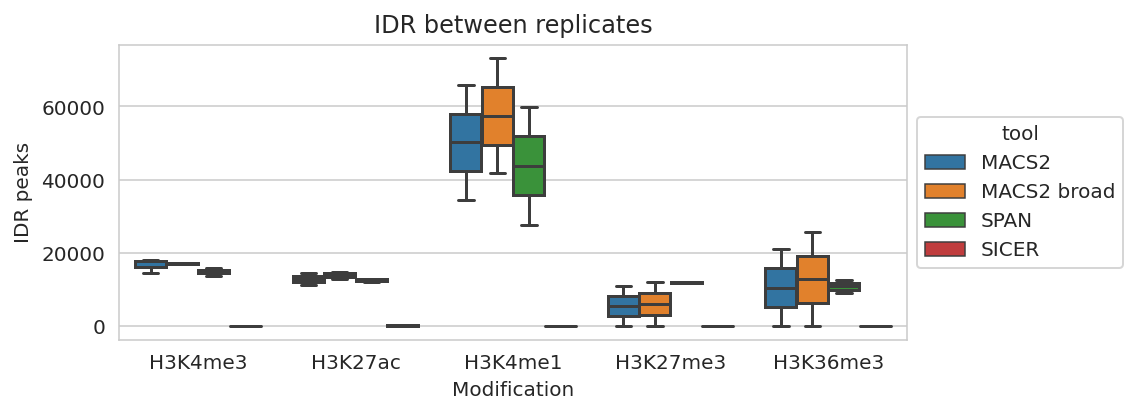

In [109]:
print('Immune')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

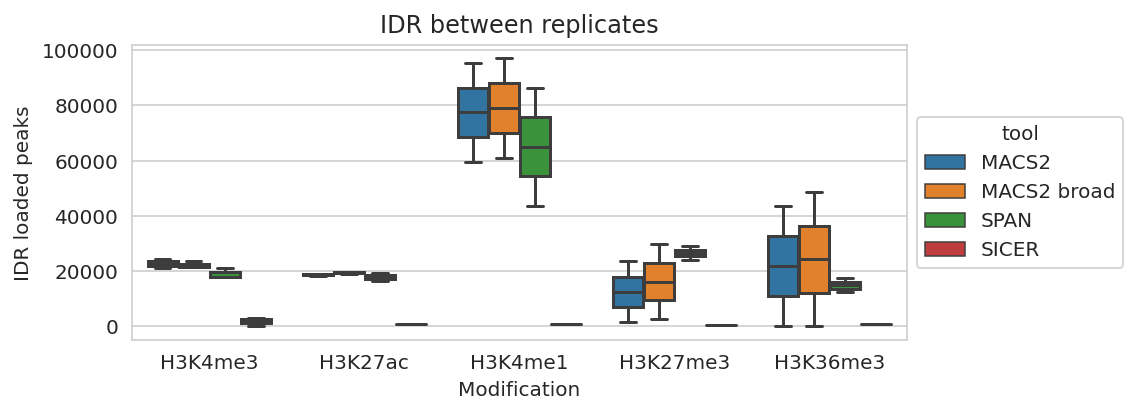

In [110]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_loaded_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR loaded peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

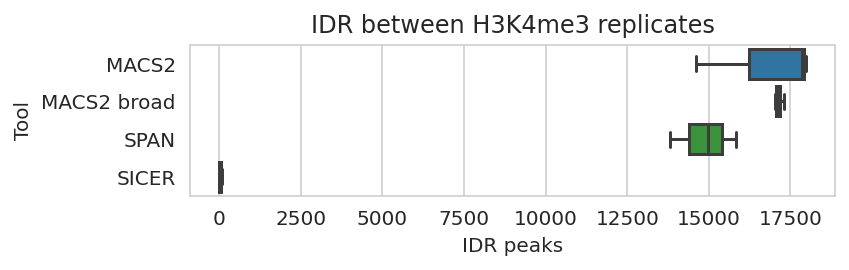

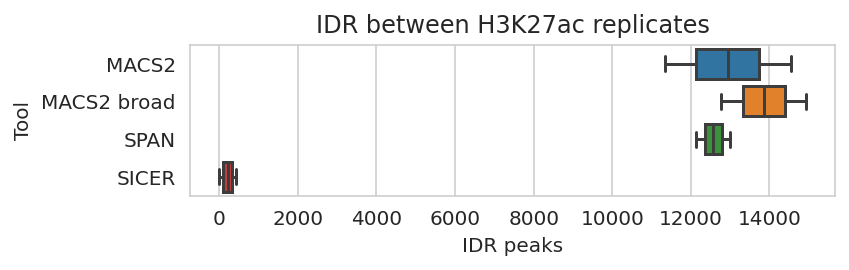

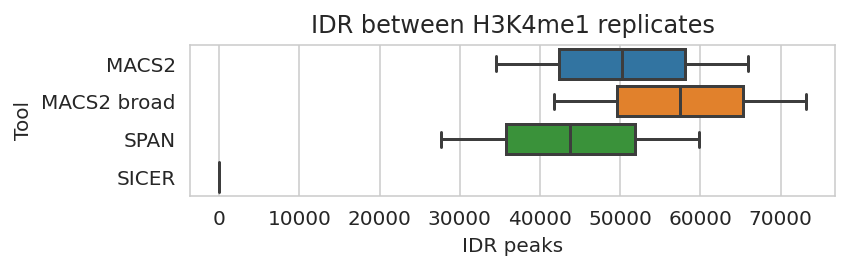

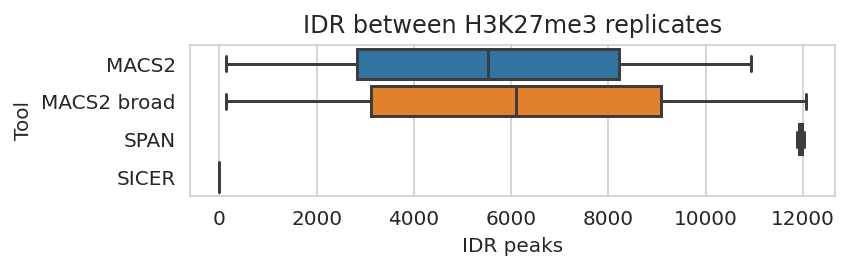

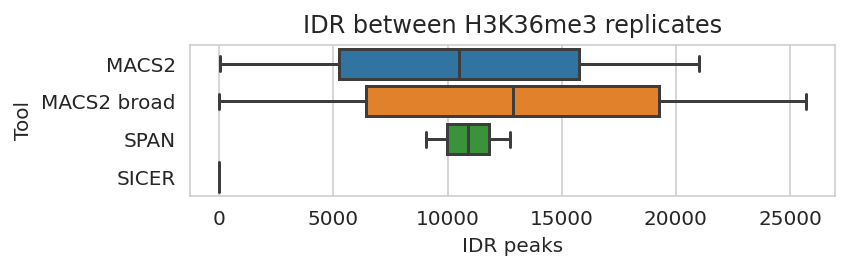

In [111]:
for m in MODIFICATIONS:
    plt.figure(figsize=(6, 2))
    g_result = sns.boxplot(data=df_immune_idr_reps[df_immune_idr_reps['modification'] == m],
                           x='idr_peaks', y = 'tool',
                           palette=TOOLS_PALETTE,
                           order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                           )
    ax = g_result.axes
    ax.set_title(f'IDR between {m} replicates')
    ax.set_ylabel('Tool')
    ax.set_xlabel('IDR peaks')
    plt.tight_layout()
    plt.show()

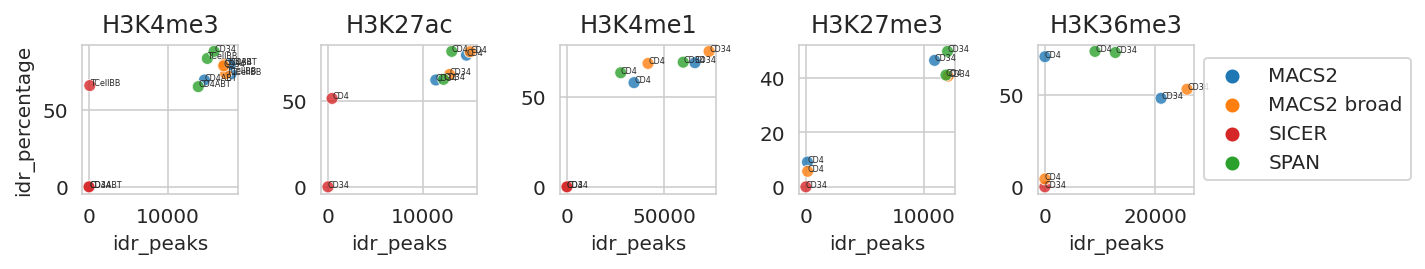

In [112]:
plt.figure(figsize=(10, 2))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_immune_idr_reps[df_immune_idr_reps['modification'] == m]
    g_results = sns.scatterplot(data=t,
                    x='idr_peaks', y='idr_percentage',
                    hue='tool',
                    palette=TOOLS_PALETTE,
                    alpha=0.8,
                    ax=ax,
                    )
    for x, y, cell in zip(t['idr_peaks'], t['idr_percentage'], t['cell']):
        ax.text(x, y, cell, fontsize = 4)    
    ax.title.set_text(m)
    if i != 0:
        ax.set_ylabel(None)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()